# AIS WBM
---
### Script for the WBM side of GBM
+ The saved, optimised trained model will be used to predict SOG 
+ Predicted SOG then converted to STW
+ STW then will be used to predict FOC
+ Power estimation using [HoltropMennen84](https://repository.tudelft.nl/islandora/object/uuid%3Aca12a502-fc85-45e4-a078-db7284127e3c)
---
### General Remarks 
+ Please remember to save the model used in BBM part
+ This file should be saved on local directory
+ Running time is significantly shorter 
---
### Package initialisation
+ Loading of standard packages

In [1]:
import pandas as pd
import numpy as np
import math
import joblib
import matplotlib.pyplot as plt
# Gridpsec used for plotting
import matplotlib.gridspec as gridspec

### Loading of models 

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')

model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')

model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

### Loading dataset

In [3]:
dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

### Same as main script, preprocessing of current and wind 

In [4]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [5]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
count,7453.000000,7453.000000,5941.000000,5941.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.016286,0.003318,8.870751,242.699284
std,5.296850,4.429899,0.099475,0.081795,8.619512,108.555287
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241
25%,-1.756650,-2.534061,-0.037983,-0.044471,0.000000,124.116508
50%,2.294543,0.385690,0.019269,0.003562,6.953578,283.216008
75%,5.838650,3.339456,0.072372,0.047412,18.014436,346.200000
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115


Imputing value in the preprocessed dataset

In [6]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [7]:
x_pre = imputer.transform(dfpre)

In [8]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [9]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [10]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [11]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))


In [12]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [13]:
# Descriptive statistics of the dataset for true north weather direction

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [14]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


### SOG threshold
+ The threshold for the ships manouvering speed will be 5 knots ([Abebe20](https://doi.org/10.3390/app10072325),[Yan21](https://doi.org/10.1016/j.tre.2020.101930))
+ Alternatively, outlier rejection using &mu; &plusmn; 3&sigma; ([Gkerekos19](https://doi.org/10.1016/j.oceaneng.2019.106282)), this should increase the threshold to about 8 knots

In [15]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

# # Improve model performance ? , reduce skew of the dataset by removing outliers mu pm 3sigma 

# df = df[df['SOG'] > 8 ]

### Data split into testing dataset
+ The `random_state` is 42, however to gain different datasets, change the `random_state` to other numbers (arbitrary), but make sure the same ``random_state`` is applied to the main BBM script that is used for the split
+ The testing dataset is further split into
    + Summer dataset ``dfsummer``
    + Winter dataset ``dfwinter``
    + Year dataset ``dfyear``, which represents the ``test_set``

In [16]:
# Exclude data for the month of June to check the model's forecasting performance 

from sklearn.model_selection import train_test_split

#When performing the split, make sure that the random state is the same as the training script

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

print("Summer Dataset Breakdown")
dfMay = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-05']
print(f"length of May dataset {len(dfMay)}")
dfJune = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-06']
print(f"length of June dataset {len(dfJune)}")
dfJuly = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-07']
print(f"length of July dataset {len(dfJuly)}")
dfAug = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-08']
print(f"length of August dataset {len(dfAug)}")
dfSep = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-09']
print(f"length of Sept dataset {len(dfSep)}")
dfOct = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-10']
print(f"length of Oct dataset {len(dfOct)}")

print("Winter Dataset Breakdown")
dfNov = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-11']
print(f"length of Nov dataset {len(dfNov)}")
dfDec = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-12']
print(f"length of Dec dataset {len(dfDec)}")
dfJan = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-01']
print(f"length of Jan dataset {len(dfJan)}")
dfFeb = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-02']
print(f"length of Feb dataset {len(dfFeb)}")
dfMar = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-03']
print(f"length of March dataset {len(dfMar)}")
dfApr = test_set[test_set['Time'].dt.strftime('%Y-%m') == '2021-04']
print(f"length of April dataset {len(dfApr)}")


frames_summer = [dfMay,dfJune,dfJuly,dfAug,dfSep,dfOct]
frames_winter = [dfNov,dfDec,dfJan,dfFeb,dfMar,dfApr]

dfsummer = pd.concat(frames_summer)
dfwinter = pd.concat(frames_winter)
dfyear = test_set

Summer Dataset Breakdown
length of May dataset 52
length of June dataset 78
length of July dataset 71
length of August dataset 86
length of Sept dataset 91
length of Oct dataset 76
Winter Dataset Breakdown
length of Nov dataset 79
length of Dec dataset 87
length of Jan dataset 104
length of Feb dataset 64
length of March dataset 85
length of April dataset 84


Descriptive statistics of different datasets

In [17]:
print(dfsummer.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   454.000000  454.000000  454.000000                454.000000   
mean   4379.918502   13.461290   55.234028                285.589553   
std    1781.342388    0.754357    0.103373                  5.899112   
min      96.000000   12.219382   55.056343                269.270386   
25%    3314.000000   12.873213   55.144445                282.898376   
50%    4521.500000   13.436779   55.222487                286.700684   
75%    5750.750000   14.084231   55.273789                290.039307   
max    7499.000000   14.671659   55.609090                295.699951   

       Air density above oceans  Max wave height  Swell period  \
count                439.000000       416.000000    416.000000   
mean                   1.230196         1.568078      4.143271   
std                    0.029182         1.277127      1.157140   
min                    1.176436         0.132310      2.019747   
25%                  

In [18]:
print(dfwinter.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   503.000000  503.000000  503.000000                503.000000   
mean   3472.200795   13.399290   55.244343                279.291783   
std    2674.645833    0.773196    0.107981                  5.441286   
min       8.000000   12.217122   55.093126                267.245300   
25%    1160.500000   12.614322   55.149434                275.740845   
50%    2516.000000   13.330516   55.232907                278.215088   
75%    6655.500000   14.075363   55.326505                281.254150   
max    7976.000000   14.676100   55.458259                292.722778   

       Air density above oceans  Max wave height  Swell period  \
count                488.000000       450.000000    450.000000   
mean                   1.259511         1.381991      4.123351   
std                    0.030108         0.919409      0.945212   
min                    1.191707         0.083379      1.681843   
25%                  

In [19]:
print(dfyear.describe())

        Unnamed: 0         LON         LAT  Temperature above oceans  \
count   957.000000  957.000000  957.000000                957.000000   
mean   3902.821317   13.428703   55.239449                282.279440   
std    2337.889892    0.764546    0.105891                  6.475851   
min       8.000000   12.217122   55.056343                267.245300   
25%    1832.000000   12.857662   55.146454                276.796387   
50%    3891.000000   13.397246   55.228287                281.913574   
75%    5882.000000   14.079568   55.277420                288.423340   
max    7976.000000   14.676100   55.609090                295.699951   

       Air density above oceans  Max wave height  Swell period  \
count                927.000000       866.000000    866.000000   
mean                   1.245628         1.471381      4.132920   
std                    0.033076         1.109037      1.051785   
min                    1.176436         0.083379      1.681843   
25%                  

### Data Preprocessing
+ Similar to BBM
+ Ensure that the dataset have identical data structure for the trained model 

In [20]:
# For Summer
dfsummer= dfsummer.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For Winter
dfwinter= dfwinter.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
# For the whole year of 2021
dfyear= dfyear.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)


In [21]:
#For Summer
dfsummer= dfsummer.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For Winter
dfwinter= dfwinter.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 
#For the whole year
dfyear= dfyear.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [22]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

# For summer 

df_summer = dfsummer[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# For Winter

df_winter = dfwinter[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]
# For the whole year

df_year = dfyear[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir']]

Imputing to complete the data

In [23]:
import numpy as np
from sklearn.impute import KNNImputer

imputer_s = KNNImputer(n_neighbors=50)
imputer_s.fit(df_summer)

# Transform imputed summer dataset

xsummer = imputer_s.transform(df_summer)

# Column heading set same

df_summer_tr = pd.DataFrame(xsummer, columns=df_summer.columns, index=df_summer.index)

In [24]:
# Impute for winter data 

imputer_w = KNNImputer(n_neighbors=50)
imputer_w.fit(df_winter)

# Transform imputed winter dataset

xwinter = imputer_w.transform(df_winter)

#Column heading set same 

df_winter_tr = pd.DataFrame(xwinter, columns=df_winter.columns, index=df_winter.index)


In [25]:
# Impute for yearly data 

imputer_yr = KNNImputer(n_neighbors=50)
imputer_yr.fit(df_year)

# Transform imputed year dataset 

xyear = imputer_yr.transform(df_year)

#Column heading set same

df_year_tr = pd.DataFrame(xyear, columns=df_year.columns, index=df_year.index)

In [26]:
df_year_tr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,282.279440,3.686966,283.195682,0.765770,5.227477,16.992892,196.729343,188.300965,6.450577,0.094795,91.397095,90.749781,86.794721
std,6.475851,0.882359,5.717327,0.543002,0.185996,3.098953,86.724148,89.168377,3.047510,0.068851,56.239614,57.759771,55.757432
min,267.245300,1.672565,273.151367,0.075465,4.742534,5.104109,56.023445,63.486661,0.398818,0.002006,0.029076,0.261234,0.055169
25%,276.796387,3.061307,277.980225,0.374414,5.109379,16.682544,102.320635,100.855468,4.105194,0.045866,38.804565,31.517677,35.810135
50%,281.913574,3.552264,282.650024,0.626909,5.287457,18.054214,185.223256,124.244421,6.126151,0.074553,95.245992,90.435400,82.317883
75%,288.423340,4.219748,288.822632,0.945985,5.377427,18.716411,282.181107,279.379130,8.210403,0.128141,142.826897,144.654991,138.931938
max,295.699951,7.014300,294.928223,3.236886,5.657877,21.005331,319.851509,308.035345,15.852335,0.497666,179.858625,179.952696,179.810480


In [27]:
# Summer dataset
x_date_s = df_summer_tr.drop(['sog'],axis=1)
y_date_s = df_summer_tr.sog
# winter dataset
x_date_w = df_winter_tr.drop(['sog'],axis=1)
y_date_w = df_winter_tr.sog
# Year dataset
x_date_yr = df_year_tr.drop(['sog'],axis=1)
y_date_yr = df_year_tr.sog

In [28]:
print(f"Amount of the test dataset is {len(x_date_yr)}")
print(f"Amount of the summer dataset is {len(x_date_s)}")
print(f"Amount of the winter dataset is {len(x_date_w)}")

Amount of the test dataset is 957
Amount of the summer dataset is 454
Amount of the winter dataset is 503


Histogram plots of the yearly dataset

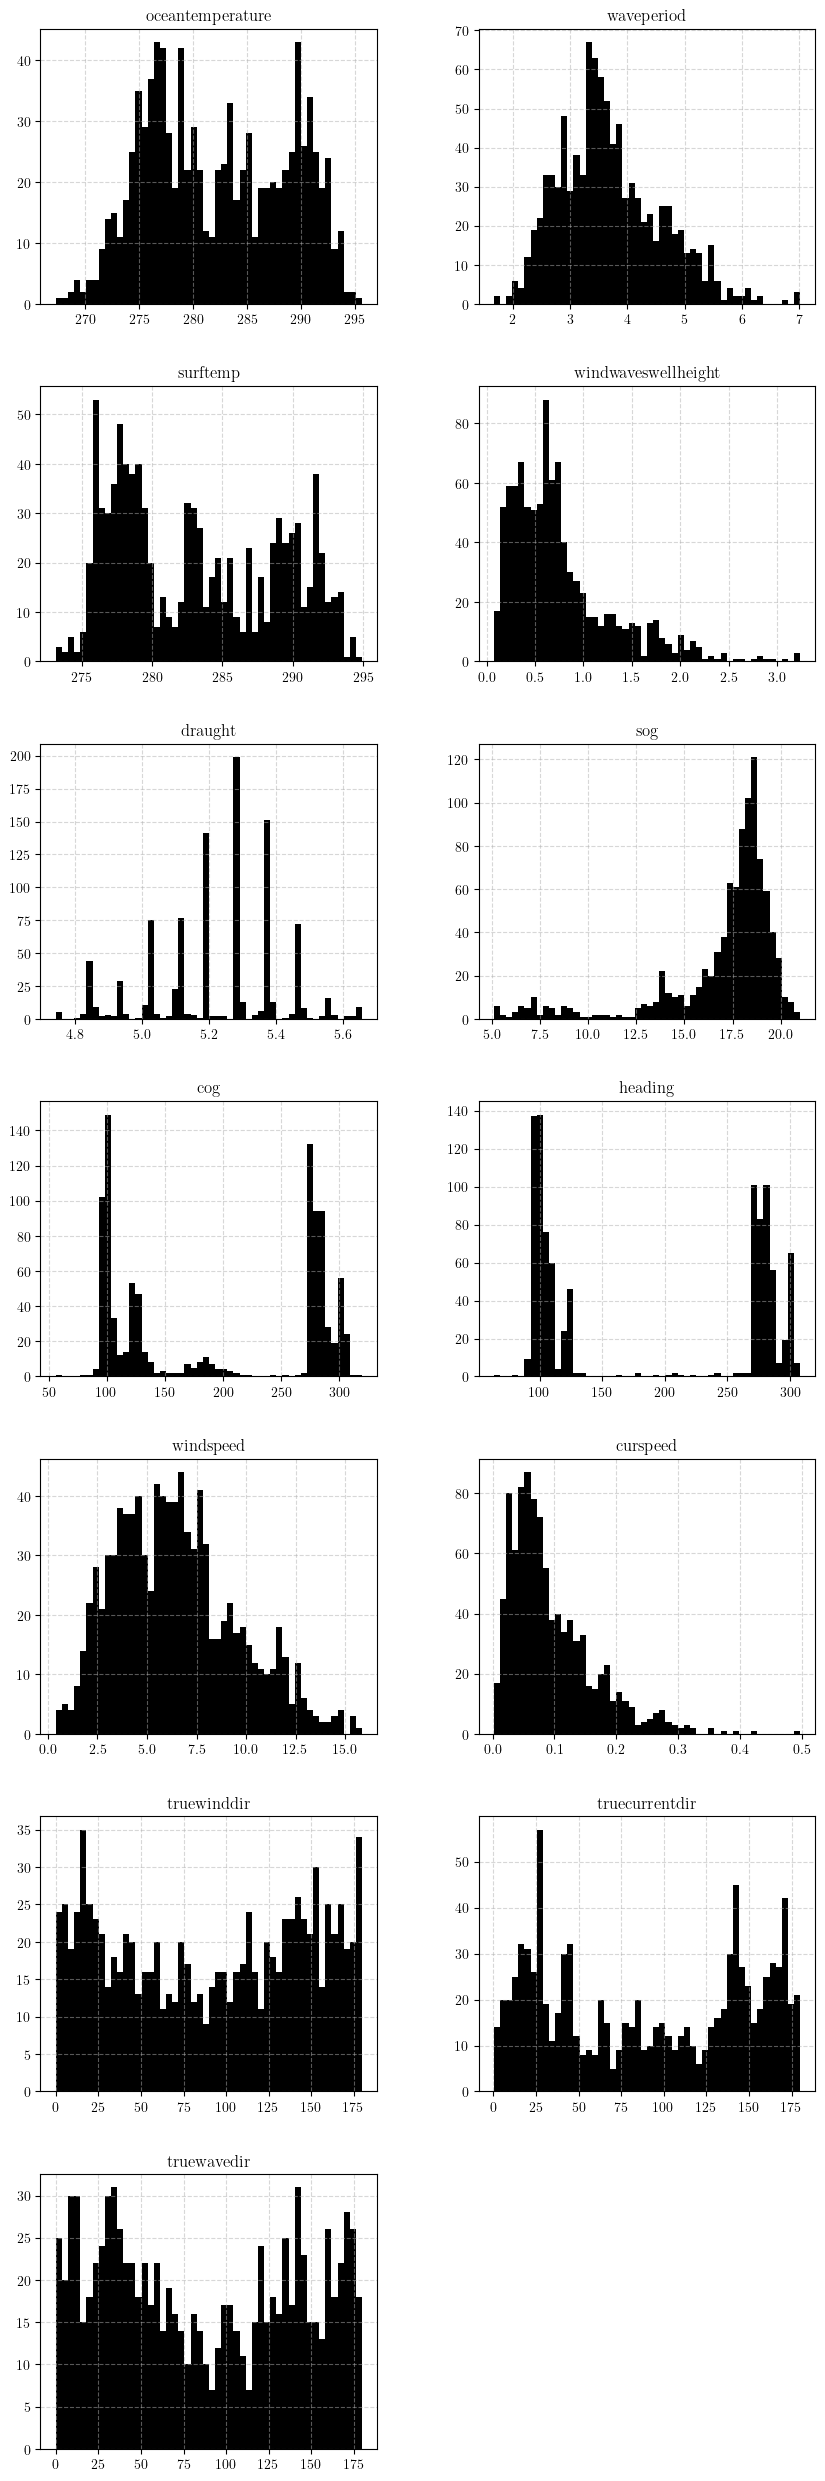

In [29]:
# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_year_tr.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [30]:
x_date_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,282.279440,3.686966,283.195682,0.765770,5.227477,196.729343,188.300965,6.450577,0.094795,91.397095,90.749781,86.794721
std,6.475851,0.882359,5.717327,0.543002,0.185996,86.724148,89.168377,3.047510,0.068851,56.239614,57.759771,55.757432
min,267.245300,1.672565,273.151367,0.075465,4.742534,56.023445,63.486661,0.398818,0.002006,0.029076,0.261234,0.055169
25%,276.796387,3.061307,277.980225,0.374414,5.109379,102.320635,100.855468,4.105194,0.045866,38.804565,31.517677,35.810135
50%,281.913574,3.552264,282.650024,0.626909,5.287457,185.223256,124.244421,6.126151,0.074553,95.245992,90.435400,82.317883
75%,288.423340,4.219748,288.822632,0.945985,5.377427,282.181107,279.379130,8.210403,0.128141,142.826897,144.654991,138.931938
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,308.035345,15.852335,0.497666,179.858625,179.952696,179.810480


In [31]:
# Ignore this part for latex export

# stats_DSyear = x_date_yr.describe().transpose()
# print(stats_DSyear.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [32]:
y_date_yr.describe()

count    957.000000
mean      16.992892
std        3.098953
min        5.104109
25%       16.682544
50%       18.054214
75%       18.716411
max       21.005331
Name: sog, dtype: float64

In [33]:
x_date_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,285.589553,3.726011,286.400159,0.817799,5.298229,196.058776,188.075527,6.638722,0.095515,90.944052,83.648221,87.789992
std,5.899112,0.993906,5.085924,0.629623,0.165597,87.546749,89.016268,3.327474,0.072561,58.052230,59.525944,59.580132
min,269.270386,2.019747,274.747070,0.084262,4.742534,56.023445,63.486661,0.398818,0.002006,0.598850,0.261234,0.090890
25%,282.898376,2.945056,283.176636,0.356768,5.199742,102.802789,100.752155,4.075977,0.042539,38.395213,26.684098,32.490880
50%,286.700684,3.573211,287.809570,0.652900,5.290759,182.786892,124.681623,6.303913,0.073974,89.864986,70.507662,82.336582
75%,290.039307,4.362177,290.184113,1.021602,5.381593,282.032566,278.068077,8.708087,0.132445,145.861449,143.729913,145.084627
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,303.295177,15.852335,0.497666,179.576603,179.325689,179.810480


In [34]:
# # Ignore this part for latex export

# stats_DSsummer = x_date_s.describe().transpose()
# print(stats_DSsummer.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [35]:
y_date_s.describe()

count    454.000000
mean      17.264115
std        2.910371
min        5.224523
25%       16.740121
50%       18.172679
75%       18.949954
max       21.005331
Name: sog, dtype: float64

In [36]:
x_date_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,279.291783,3.666570,280.298144,0.726830,5.163618,197.334587,188.504441,6.280760,0.094145,91.806005,97.159540,86.285157
std,5.441286,0.761638,4.674192,0.444364,0.180340,86.057678,89.393560,2.763034,0.065388,54.606739,55.399755,51.481263
min,267.245300,1.672565,273.151367,0.075465,4.755055,80.805636,89.221494,0.427826,0.003022,0.029076,1.444688,0.055169
25%,275.740845,3.158122,277.230103,0.395192,5.020568,102.253912,100.874351,4.116934,0.048672,39.664718,41.918483,40.297085
50%,278.215088,3.612392,278.674072,0.659816,5.199700,187.556009,123.916325,6.047215,0.075327,97.923209,102.124889,82.361955
75%,281.254150,4.129223,282.312134,0.888074,5.289907,282.634606,280.047244,8.008357,0.124327,140.204666,145.342033,131.521413
max,292.722778,5.978095,292.849853,2.434368,5.654461,307.924559,308.035345,14.347213,0.418802,179.858625,179.952696,178.295216


In [37]:
# # Ignore this part for latex export

# stats_DSwinter = x_date_w.describe().transpose()
# print(stats_DSwinter.to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

In [38]:
y_date_w.describe()

count    503.000000
mean      16.748089
std        3.243255
min        5.104109
25%       16.593366
50%       17.977196
75%       18.612312
max       20.701952
Name: sog, dtype: float64

### Evaluating model performance on the testing datasets
+ Same metrics used for cross validation, but now MAPE is added

In [39]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = np.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

ETR

In [40]:
# Year dataset
evaluate_SOG(model_etr_hpov,x_date_yr,y_date_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9188
Explained Variance SOG = 0.9189
MSE SOG = 0.5819 Knots
RMSE SOG = 0.8827 Knots
MAD SOG = 0.3967 Knots
MAPE SOG = 3.9596 %


In [41]:
evaluate_SOG(model_etr_hpov,x_date_w,y_date_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9456
Explained Variance SOG = 0.9463
MSE SOG = 0.5315 Knots
RMSE SOG = 0.7560 Knots
MAD SOG = 0.3943 Knots
MAPE SOG = 3.7122 %


In [42]:
evaluate_SOG(model_etr_hpov,x_date_s,y_date_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.8814
Explained Variance SOG = 0.8815
MSE SOG = 0.6349 Knots
RMSE SOG = 1.0013 Knots
MAD SOG = 0.4089 Knots
MAPE SOG = 4.1970 %


RFR

In [43]:
evaluate_SOG(model_rfr_hpov,x_date_yr,y_date_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9010
Explained Variance SOG = 0.9013
MSE SOG = 0.6187 Knots
RMSE SOG = 0.9743 Knots
MAD SOG = 0.4173 Knots
MAPE SOG = 4.2908 %


In [44]:
evaluate_SOG(model_rfr_hpov,x_date_w,y_date_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9341
Explained Variance SOG = 0.9353
MSE SOG = 0.5482 Knots
RMSE SOG = 0.8318 Knots
MAD SOG = 0.3724 Knots
MAPE SOG = 3.9431 %


In [45]:
evaluate_SOG(model_rfr_hpov,x_date_s,y_date_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.8548
Explained Variance SOG = 0.8548
MSE SOG = 0.6939 Knots
RMSE SOG = 1.1078 Knots
MAD SOG = 0.4516 Knots
MAPE SOG = 4.6275 %


DTR


In [46]:
evaluate_SOG(model_dtr_hpov,x_date_yr,y_date_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8673
Explained Variance SOG = 0.8675
MSE SOG = 0.7139 Knots
RMSE SOG = 1.1283 Knots
MAD SOG = 0.4796 Knots
MAPE SOG = 4.9561 %


In [47]:
evaluate_SOG(model_dtr_hpov,x_date_w,y_date_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8852
Explained Variance SOG = 0.8862
MSE SOG = 0.6889 Knots
RMSE SOG = 1.0976 Knots
MAD SOG = 0.4410 Knots
MAPE SOG = 4.9261 %


In [48]:
evaluate_SOG(model_dtr_hpov,x_date_s,y_date_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8410
Explained Variance SOG = 0.8410
MSE SOG = 0.7376 Knots
RMSE SOG = 1.1593 Knots
MAD SOG = 0.5156 Knots
MAPE SOG = 4.9157 %


MLR

In [49]:
evaluate_SOG(model_mlr_ftr,x_date_yr,y_date_yr)

Model Performance of LinearRegression()
R^2 SOG = 0.6957
Explained Variance SOG = 0.6962
MSE SOG = 1.1474 Knots
RMSE SOG = 1.7086 Knots
MAD SOG = 0.9172 Knots
MAPE SOG = 7.7454 %


In [50]:
evaluate_SOG(model_mlr_ftr,x_date_s,y_date_s)

Model Performance of LinearRegression()
R^2 SOG = 0.7124
Explained Variance SOG = 0.7163
MSE SOG = 1.1587 Knots
RMSE SOG = 1.5590 Knots
MAD SOG = 0.9517 Knots
MAPE SOG = 7.3809 %


In [51]:
evaluate_SOG(model_mlr_ftr,x_date_w,y_date_w)

Model Performance of LinearRegression()
R^2 SOG = 0.6782
Explained Variance SOG = 0.6783
MSE SOG = 1.1331 Knots
RMSE SOG = 1.8379 Knots
MAD SOG = 0.8753 Knots
MAPE SOG = 8.0486 %


### Plot of predicted vs actual SOG values

In [52]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.3f}x {b:+.3f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend(fontsize=14)



0.8672885569417756
y = 0.9 * x + 2.2
0.9010443844092885
y = 0.9 * x + 2.0


0.9187906839130218
y = 0.9 * x + 2.0


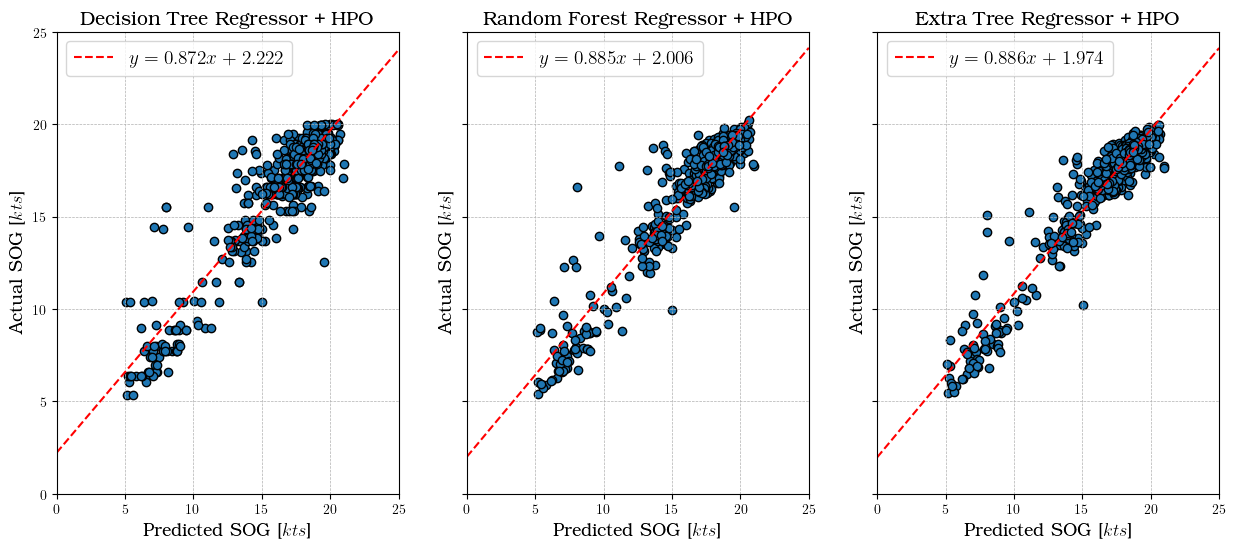

In [53]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.sca(axes[2])
pred_plot(model_etr_hpov,'Extra Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.show()

0.8167288982227823
y = 0.9 * x + 1.8
0.8672885569417756
y = 0.9 * x + 2.2


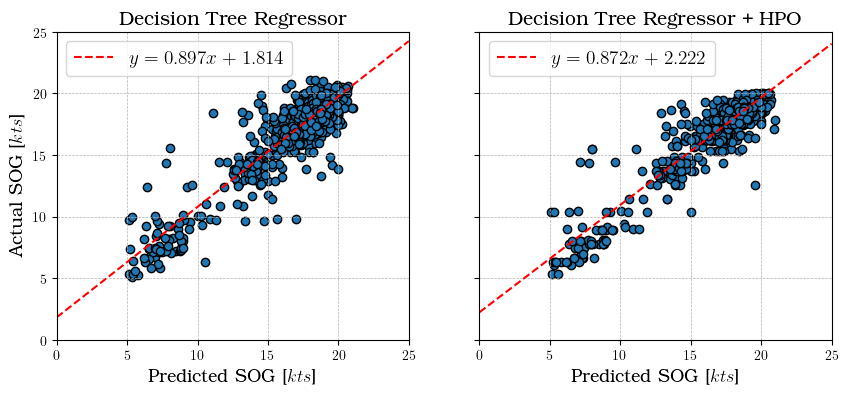

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.8926948852520443
y = 0.9 * x + 2.1
0.9010443844092885
y = 0.9 * x + 2.0


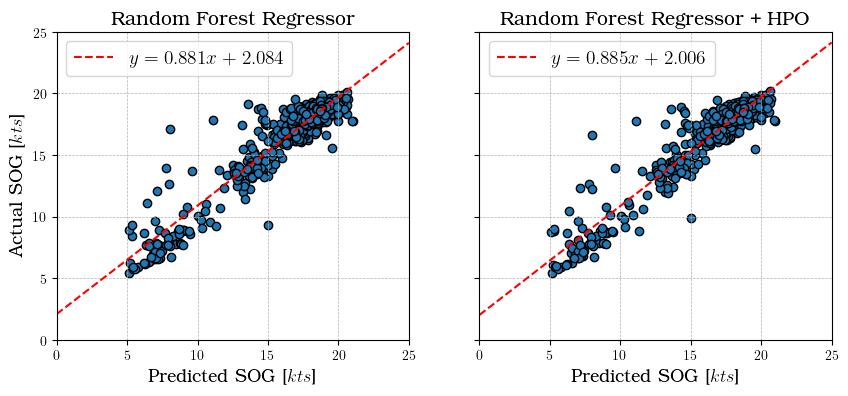

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

0.9230248673757001
y = 0.9 * x + 1.8
0.9187906839130218
y = 0.9 * x + 2.0


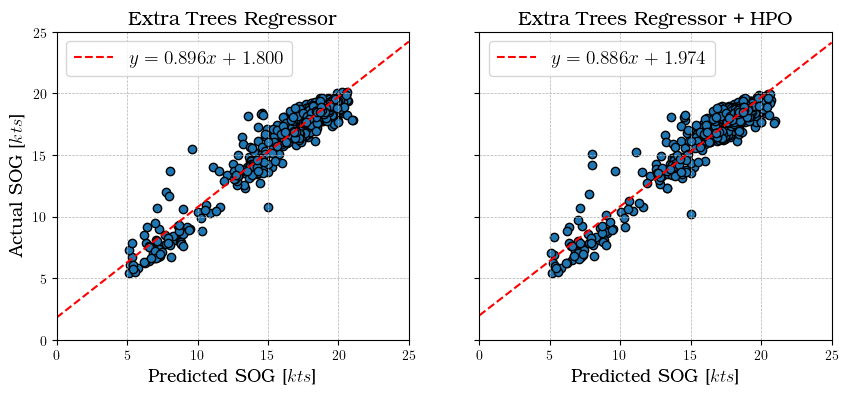

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date_yr,y_date_yr)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date_yr,y_date_yr)
plt.ylabel("")
plt.show()

### Conversion to STW 
+ Considered only effect of current per [Kim20b](https://doi.org/10.1016/j.ijnaoe.2020.03.007)

In [57]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

#Test data

# ETR
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)

# RFR
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)


# DTR
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)

# MLR  
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
ydate_pred__mlr_yr = label_predict(model_mlr_ftr,x_date_yr)


# For actual results

# Yearly dataset

dfprog_sog_yr = pd.Series(y_date_yr,name="sog_act_yr").to_frame()
ydate_pred_yr = label_predict(model_etr_hpov,x_date_yr)
ydate_pred_rf_yr = label_predict(model_rfr_hpov,x_date_yr)
ydate_pred_dt_yr = label_predict(model_dtr_hpov,x_date_yr)
ydate_pred_mlr_yr = label_predict(model_mlr_ftr,x_date_yr)
dfprog_sog_yr["sog_pred_yr"] = ydate_pred_yr
dfprog_sog_yr["sog_pred_rf_yr"] = ydate_pred_rf_yr
dfprog_sog_yr["sog_pred_dt_yr"] = ydate_pred_dt_yr
dfprog_sog_yr["sog_pred_mlr_yr"] = ydate_pred_mlr_yr
dfprog_sog_yr["gamma_yr"] = dfyear["truenorthcurrentdir"]
dfprog_sog_yr["nwinddir_yr"] = dfyear["truenorthwinddir"]
dfprog_yr = pd.concat([x_date_yr,dfprog_sog_yr],axis=1)


# Winter dataset
dfprog_sog_w = pd.Series(y_date_w,name="sog_act_w").to_frame()
ydate_pred_w = label_predict(model_etr_hpov,x_date_w)
ydate_pred_rf_w = label_predict(model_rfr_hpov,x_date_w)
ydate_pred_dt_w = label_predict(model_dtr_hpov,x_date_w)
ydate_pred_mlr_w = label_predict(model_mlr_ftr,x_date_w)
dfprog_sog_w["sog_pred_w"] = ydate_pred_w
dfprog_sog_w["sog_pred_rf_w"] = ydate_pred_rf_w
dfprog_sog_w["sog_pred_dt_w"] = ydate_pred_dt_w
dfprog_sog_w["sog_pred_mlr_w"] = ydate_pred_mlr_w
dfprog_sog_w["gamma_w"] = dfwinter["truenorthcurrentdir"]
dfprog_sog_w["nwinddir_w"] = dfwinter["truenorthwinddir"]
dfprog_w = pd.concat([x_date_w,dfprog_sog_w],axis=1)

# Summer Dataset
dfprog_sog_s = pd.Series(y_date_s,name="sog_act_s").to_frame()
ydate_pred_s = label_predict(model_etr_hpov,x_date_s)
ydate_pred_rf_s = label_predict(model_rfr_hpov,x_date_s)
ydate_pred_dt_s = label_predict(model_dtr_hpov,x_date_s)
ydate_pred_mlr_s = label_predict(model_mlr_ftr,x_date_s)
dfprog_sog_s["sog_pred_s"] = ydate_pred_s
dfprog_sog_s["sog_pred_rf_s"] = ydate_pred_rf_s
dfprog_sog_s["sog_pred_dt_s"] = ydate_pred_dt_s
dfprog_sog_s["sog_pred_mlr_s"] = ydate_pred_mlr_s
dfprog_sog_s["gamma_s"] = dfsummer["truenorthcurrentdir"]
dfprog_sog_s["nwinddir_s"] = dfsummer["truenorthwinddir"]
dfprog_s = pd.concat([x_date_s,dfprog_sog_s],axis=1)


In [58]:
dfprog_yr.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_yr,sog_pred_yr,sog_pred_rf_yr,sog_pred_dt_yr,sog_pred_mlr_yr,gamma_yr,nwinddir_yr
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,282.279440,3.686966,283.195682,0.765770,5.227477,196.729343,188.300965,6.450577,0.094795,91.397095,90.749781,86.794721,16.992892,17.027244,17.045482,17.042023,16.920935,152.594366,198.620460
std,6.475851,0.882359,5.717327,0.543002,0.185996,86.724148,89.168377,3.047510,0.068851,56.239614,57.759771,55.757432,3.098953,2.861779,2.888433,2.901738,2.475250,100.468944,91.556109
min,267.245300,1.672565,273.151367,0.075465,4.742534,56.023445,63.486661,0.398818,0.002006,0.029076,0.261234,0.055169,5.104109,5.430487,5.390854,5.361528,4.472661,0.335373,0.232451
25%,276.796387,3.061307,277.980225,0.374414,5.109379,102.320635,100.855468,4.105194,0.045866,38.804565,31.517677,35.810135,16.682544,16.669291,16.713103,16.578242,17.167826,77.207028,139.551166
50%,281.913574,3.552264,282.650024,0.626909,5.287457,185.223256,124.244421,6.126151,0.074553,95.245992,90.435400,82.317883,18.054214,18.054795,18.109655,18.112733,17.674260,123.761356,203.575325
75%,288.423340,4.219748,288.822632,0.945985,5.377427,282.181107,279.379130,8.210403,0.128141,142.826897,144.654991,138.931938,18.716411,18.645150,18.700514,18.664988,17.981425,231.331274,274.642505
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,308.035345,15.852335,0.497666,179.858625,179.952696,179.810480,21.005331,19.960362,20.216676,19.996240,24.181325,359.450078,358.907188


In [59]:
dfprog_w.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_w,sog_pred_w,sog_pred_rf_w,sog_pred_dt_w,sog_pred_mlr_w,gamma_w,nwinddir_w
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,279.291783,3.666570,280.298144,0.726830,5.163618,197.334587,188.504441,6.280760,0.094145,91.806005,97.159540,86.285157,16.748089,16.836674,16.860059,16.849673,16.773158,152.756617,203.426871
std,5.441286,0.761638,4.674192,0.444364,0.180340,86.057678,89.393560,2.763034,0.065388,54.606739,55.399755,51.481263,3.243255,3.042790,3.040718,3.058147,2.654633,100.407252,94.158165
min,267.245300,1.672565,273.151367,0.075465,4.755055,80.805636,89.221494,0.427826,0.003022,0.029076,1.444688,0.055169,5.104109,5.384333,5.357662,5.361528,4.618303,0.335373,0.232451
25%,275.740845,3.158122,277.230103,0.395192,5.020568,102.253912,100.874351,4.116934,0.048672,39.664718,41.918483,40.297085,16.593366,16.648277,16.701903,16.578242,17.011631,78.133231,147.858709
50%,278.215088,3.612392,278.674072,0.659816,5.199700,187.556009,123.916325,6.047215,0.075327,97.923209,102.124889,82.361955,17.977196,17.954643,18.017749,17.858925,17.525937,122.967211,205.983056
75%,281.254150,4.129223,282.312134,0.888074,5.289907,282.634606,280.047244,8.008357,0.124327,140.204666,145.342033,131.521413,18.612312,18.560657,18.596566,18.578152,17.922513,225.131044,280.202556
max,292.722778,5.978095,292.849853,2.434368,5.654461,307.924559,308.035345,14.347213,0.418802,179.858625,179.952696,178.295216,20.701952,19.865482,19.735113,19.977031,24.400050,359.264290,358.907188


In [60]:
dfprog_s.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act_s,sog_pred_s,sog_pred_rf_s,sog_pred_dt_s,sog_pred_mlr_s,gamma_s,nwinddir_s
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,285.589553,3.726011,286.400159,0.817799,5.298229,196.058776,188.075527,6.638722,0.095515,90.944052,83.648221,87.789992,17.264115,17.234212,17.245612,17.251129,17.083220,152.414603,193.295295
std,5.899112,0.993906,5.085924,0.629623,0.165597,87.546749,89.016268,3.327474,0.072561,58.052230,59.525944,59.580132,2.910371,2.651856,2.719783,2.721870,2.257080,100.647716,88.382376
min,269.270386,2.019747,274.747070,0.084262,4.742534,56.023445,63.486661,0.398818,0.002006,0.598850,0.261234,0.090890,5.224523,5.900250,5.662987,5.981428,4.783272,2.677540,1.098283
25%,282.898376,2.945056,283.176636,0.356768,5.199742,102.802789,100.752155,4.075977,0.042539,38.395213,26.684098,32.490880,16.740121,16.706790,16.735144,16.578242,17.289837,77.014658,135.047483
50%,286.700684,3.573211,287.809570,0.652900,5.290759,182.786892,124.681623,6.303913,0.073974,89.864986,70.507662,82.336582,18.172679,18.176979,18.201923,18.154850,17.751861,124.240301,201.288368
75%,290.039307,4.362177,290.184113,1.021602,5.381593,282.032566,278.068077,8.708087,0.132445,145.861449,143.729913,145.084627,18.949954,18.745138,18.772637,18.907098,18.019764,236.190471,270.937591
max,295.699951,7.014300,294.928223,3.236886,5.657877,319.851509,303.295177,15.852335,0.497666,179.576603,179.325689,179.810480,21.005331,19.960362,20.216676,19.996240,19.905067,359.450078,358.771465


In [61]:
# # Ignore for latex export
# print(dfprog_sog_s.describe())
# print(dfprog_sog_s.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# ))  

+ Boxplots showcasing the skew of the SOG

<Figure size 500x300 with 0 Axes>

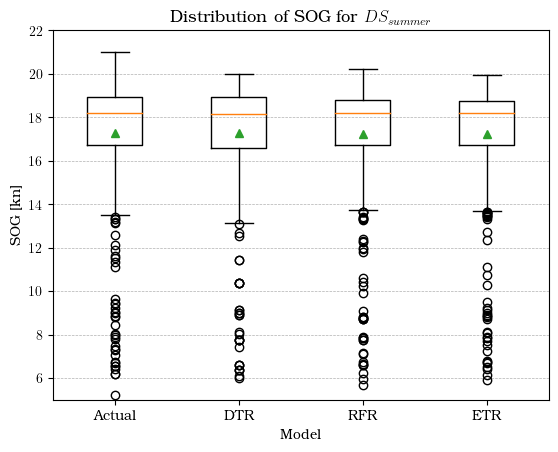

In [62]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_s['sog_act_s'],dfprog_sog_s['sog_pred_dt_s'],dfprog_sog_s['sog_pred_rf_s'],dfprog_sog_s['sog_pred_s']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{summer}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [63]:
# # Ignore for latex export
# print(dfprog_sog_w.describe())
# print(dfprog_sog_w.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 500x300 with 0 Axes>

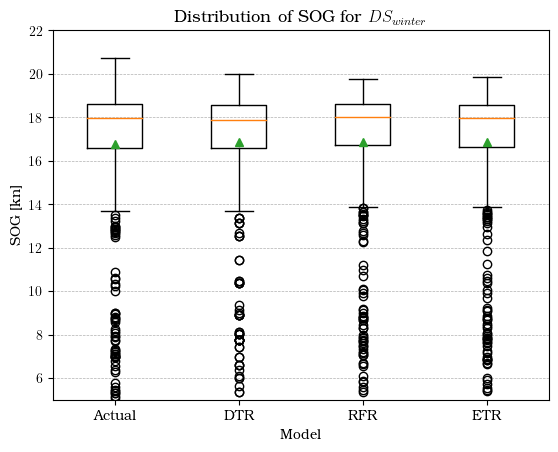

In [64]:
# Box plot of predicted results of winter dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_w['sog_act_w'],dfprog_sog_w['sog_pred_dt_w'],dfprog_sog_w['sog_pred_rf_w'],dfprog_sog_w['sog_pred_w']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{winter}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

In [65]:
# # Ignore for latex export
# print(dfprog_sog_yr.describe())
# print(dfprog_sog_yr.describe().transpose().to_latex(index=False,

#                   formatters={"name": str.upper},

#                   float_format="{:.2f}".format,

# )) 

<Figure size 500x300 with 0 Axes>

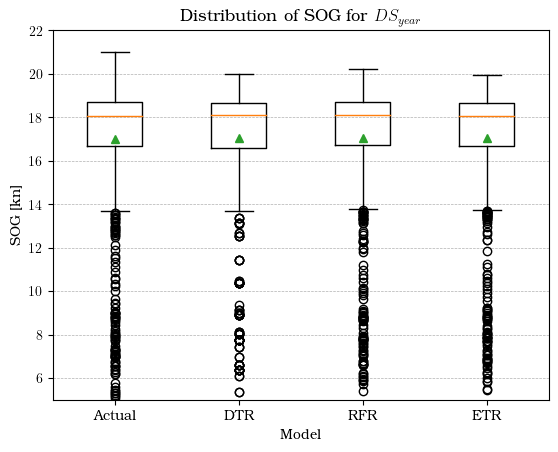

In [66]:
# Box plot of predicted results of yearly dataset

plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [dfprog_sog_yr['sog_act_yr'],dfprog_sog_yr['sog_pred_dt_yr'],dfprog_sog_yr['sog_pred_rf_yr'],dfprog_sog_yr['sog_pred_yr']]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title(r"Distribution of SOG for $DS_{year}$")
plt.ylabel("SOG [kn]")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(5,22)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['Actual', 'DTR',
                    'RFR', 'ETR'])
plt.show()

Formula for STW correction

In [67]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [68]:
# STW conversion Year

# Actual
stw_act_yr = sog_corr(dfprog_yr['sog_act_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_act_yr'] = stw_act_yr
# ETR
stw_pred_et_yr = sog_corr(dfprog_yr['sog_pred_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_yr'] = stw_pred_et_yr
# RFR
stw_pred_rf_yr = sog_corr(dfprog_yr['sog_pred_rf_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_rf_yr'] = stw_pred_rf_yr
# DTR
stw_pred_dt_yr = sog_corr(dfprog_yr['sog_pred_dt_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_dt_yr'] = stw_pred_dt_yr
# MLR
stw_pred_mlr_yr = sog_corr(dfprog_yr['sog_pred_mlr_yr'],dfprog_yr['gamma_yr'],dfprog_yr['heading'],dfprog_yr['curspeed'])
dfprog_yr['stw_pred_mlr_yr'] = stw_pred_mlr_yr



In [69]:
print(dfprog_yr.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        957.000000  957.000000  957.000000           957.000000   
mean         282.279440    3.686966  283.195682             0.765770   
std            6.475851    0.882359    5.717327             0.543002   
min          267.245300    1.672565  273.151367             0.075465   
25%          276.796387    3.061307  277.980225             0.374414   
50%          281.913574    3.552264  282.650024             0.626909   
75%          288.423340    4.219748  288.822632             0.945985   
max          295.699951    7.014300  294.928223             3.236886   

          draught         cog     heading   windspeed    curspeed  \
count  957.000000  957.000000  957.000000  957.000000  957.000000   
mean     5.227477  196.729343  188.300965    6.450577    0.094795   
std      0.185996   86.724148   89.168377    3.047510    0.068851   
min      4.742534   56.023445   63.486661    0.398818    0.002006   
25%   

In [70]:
# STW conversion Summer 

# Actual
stw_act_s = sog_corr(dfprog_s['sog_act_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_act_s'] = stw_act_s
# ETR
stw_pred_et_s = sog_corr(dfprog_s['sog_pred_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_s'] = stw_pred_et_s
# RFR
stw_pred_rf_s = sog_corr(dfprog_s['sog_pred_rf_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_rf_s'] = stw_pred_rf_s
# DTR
stw_pred_dt_s = sog_corr(dfprog_s['sog_pred_dt_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_dt_s'] = stw_pred_dt_s
# MLR
stw_pred_mlr_s = sog_corr(dfprog_s['sog_pred_mlr_s'],dfprog_s['gamma_s'],dfprog_s['heading'],dfprog_s['curspeed'])
dfprog_s['stw_pred_mlr_s'] = stw_pred_mlr_s



In [71]:
print(dfprog_s.describe())

       oceantemperature  waveperiod    surftemp  windwaveswellheight  \
count        454.000000  454.000000  454.000000           454.000000   
mean         285.589553    3.726011  286.400159             0.817799   
std            5.899112    0.993906    5.085924             0.629623   
min          269.270386    2.019747  274.747070             0.084262   
25%          282.898376    2.945056  283.176636             0.356768   
50%          286.700684    3.573211  287.809570             0.652900   
75%          290.039307    4.362177  290.184113             1.021602   
max          295.699951    7.014300  294.928223             3.236886   

          draught         cog     heading   windspeed    curspeed  \
count  454.000000  454.000000  454.000000  454.000000  454.000000   
mean     5.298229  196.058776  188.075527    6.638722    0.095515   
std      0.165597   87.546749   89.016268    3.327474    0.072561   
min      4.742534   56.023445   63.486661    0.398818    0.002006   
25%   

In [72]:
# STW conversion Winter

# Actual
stw_act_w = sog_corr(dfprog_w['sog_act_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_act_w'] = stw_act_w
# ETR
stw_pred_et_w = sog_corr(dfprog_w['sog_pred_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_w'] = stw_pred_et_w
# RFR
stw_pred_rf_w = sog_corr(dfprog_w['sog_pred_rf_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_rf_w'] = stw_pred_rf_w
# DTR
stw_pred_dt_w = sog_corr(dfprog_w['sog_pred_dt_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_dt_w'] = stw_pred_dt_w
# MLR
stw_pred_mlr_w = sog_corr(dfprog_w['sog_pred_mlr_w'],dfprog_w['gamma_w'],dfprog_w['heading'],dfprog_w['curspeed'])
dfprog_w['stw_pred_mlr_w'] = stw_pred_mlr_w

Holtrop Mennen FOC function

In [73]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots
    # V_n = 18 # ship design speed, knots


    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    # V_n = 18/1.94384

    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # print(f"lcb {lcb:0.4f}")

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.4f} m^2")
    # print(f"A_bt {A_bt:0.4f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.4f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = 2*math.pi * D_shaft * l_shaft
    k2_shaft = 3   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side (triangle)
    k2_skeg = 1.5

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.4f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke
    
    # print(f"h_B {h_b:0.4f}")

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # print(f"i_e = {i_e:0.4f}")

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = (1/16) * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl) * B

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer
    PD_const = 1.135  # From Bertram

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*PD_const
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.7 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h
    FOC_day = FOC * 11 #Per day 11 hour journey

    # print("Summary of important results")
    
    # print(f"Ship Displacement {dsp:0.4f} m^3")
    # print(f"Prismatic coefficient C_p {C_p:0.4f}")
    # print(f"Midship coefficient C_m {C_m:0.4f}")
    # print(f"Block coefficient C_b {C_b:0.4f}")
    # print(f"Waterplane area constant C_wp {C_wp:0.4f}")
    # print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Max STW {stw.max():0.2f} kt")
    # print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    # print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    # print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    # print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    # print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    # print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    # print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    # print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    # print(f"Average total resistance R_tot {R_tot.mean():0.3f}kN")
    # print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    # print(f"Average Power {P_b.mean():0.3f} kW")
    # print(f"Max Power {P_b.max():0.3f} kW")
    # print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")
    # print(f"Average Fuel Consumption per day {FOC_day.mean():0.3f} T")


    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Comparison of Summer and Winter fuel consumption

Actual Summer

In [74]:
Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s = foc_fun(dfprog_s['stw_act_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [75]:
def stats_HoltropMennen(stw,RFric,RApp,RWave,RBulb,RTrans,RCorr,RWind,RStaWave,RTot,EffTot,Pbrake,FOChr):
    WBM_desc_stats = pd.concat([stw,RFric/1e3,RApp/1e3,RWave/1e3,RBulb/1e3,pd.Series(RTrans/1e3),RCorr/1e3,RWind/1e3,pd.Series(RStaWave/1e3),RTot,EffTot,Pbrake,FOChr],axis=1)
    WBM_HM_desc = pd.DataFrame(WBM_desc_stats)
    WBM_HM_desc.columns = ['STW [m/s]','R_F [kN]', 'R_APP [kN]', 'R_W [kN]', 'R_B [kN]', 'R_TR [kN]' ,'R_A [kN]', 'R_AA [kN]' , 'R_AWL [kN]', 'R_TOT [kN]' , 'EFF_TOT [-]' ,'P_B[kW]','FOC [T/h]' ]
    # Direct print to LaTex, uncomment if needed
    # print(WBM_HM_desc.describe().transpose().to_latex(index=False,

    #               formatters={"name": str.upper},

    #               float_format="{:.2f}".format,
    # ))
    return WBM_HM_desc 


In [76]:
WBM_act_s = stats_HoltropMennen(stw_act_s,Rf_act_s,R_app_act_s,R_w_act_s,R_b_act_s,R_tr_act_s,R_a_act_s,R_aa_act_s,R_awl_act_s,R_tot_act_s,eff_tot_act_s,P_b_act_s,FOC_act_s)

In [77]:
WBM_act_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.288439,179.841250,40.515324,103.520037,70.741661,4.935979,45.629341,12.820724,4.829920,462.834235,0.666759,6451.525034,1.092888
std,2.904706,47.830041,10.945656,59.663793,10.625187,10.501738,12.474415,12.362514,14.211017,131.907785,0.000225,2433.085534,0.412165
min,5.196163,17.837753,3.717858,0.000047,16.823968,0.000000,4.008739,0.011120,0.000000,102.154092,0.666082,409.026910,0.069289
25%,16.690357,164.043529,36.812306,63.052947,68.558606,0.000000,41.397990,2.977885,0.000000,387.139123,0.666647,4993.061814,0.845825
50%,18.169935,192.557481,43.506833,106.347760,74.028554,0.000000,48.994862,8.648291,0.000000,487.076978,0.666769,6839.645785,1.158636
75%,19.018851,209.703661,47.596274,140.544159,77.231699,4.418813,53.756106,19.169638,1.767753,547.445553,0.666871,8042.722680,1.362437
max,21.075655,262.253211,58.253888,297.525440,82.196501,53.315426,66.226756,59.496182,116.180900,784.721551,0.667615,12755.900961,2.160850


Actual Winter

In [78]:
Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w = foc_fun(dfprog_w['stw_act_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [79]:
WBM_act_w = stats_HoltropMennen(stw_act_w,Rf_act_w,R_app_act_w,R_w_act_w,R_b_act_w,R_tr_act_w,R_a_act_w,R_aa_act_w,R_awl_act_w,R_tot_act_w,eff_tot_act_w,P_b_act_w,FOC_act_w)

In [80]:
WBM_act_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.800266,169.972602,38.620276,90.176920,71.673723,6.160121,43.381072,11.541186,2.185493,433.711392,0.666625,5921.908853,1.003171
std,3.245612,50.089140,11.535893,50.654738,11.873508,12.493110,13.096194,10.161083,7.399220,125.392812,0.000260,2268.502267,0.384284
min,5.137868,17.172416,3.636451,0.000037,15.594036,0.000000,3.921901,0.010456,0.000000,95.347874,0.666030,377.454251,0.063941
25%,16.533679,159.544746,36.135654,58.634056,70.912534,0.000000,40.558670,3.116108,0.000000,386.397909,0.666471,4914.930379,0.832589
50%,17.988086,186.536224,42.654359,98.576585,75.962308,0.000000,47.889820,8.963067,0.000000,463.164438,0.666615,6438.327102,1.090653
75%,18.663986,201.357540,45.864791,123.928947,77.974893,5.085324,51.604721,17.638496,0.533181,515.593612,0.666780,7393.946053,1.252534
max,20.640250,247.308062,55.909346,251.220661,82.132439,53.563413,63.330308,51.230868,68.247082,714.872025,0.667712,11385.076293,1.928632


Actual Year

In [81]:
Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr = foc_fun(dfprog_yr['stw_act_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [82]:
WBM_act_yr = stats_HoltropMennen(stw_act_yr,Rf_act_yr,R_app_act_yr,R_w_act_yr,R_b_act_yr,R_tr_act_yr,R_a_act_yr,R_aa_act_yr,R_awl_act_yr,R_tot_act_yr,eff_tot_act_yr,P_b_act_yr,FOC_act_yr)

In [83]:
WBM_act_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.031855,174.654280,39.519285,96.506883,71.231553,5.579389,44.447649,12.148198,3.486221,447.573459,0.666688,6173.396642,1.045773
std,3.096603,49.252278,11.293640,55.485138,11.302266,11.601310,12.847518,11.271366,11.232802,129.159164,0.000253,2361.016121,0.399956
min,5.137868,17.172416,3.636451,0.000037,15.594036,0.000000,3.921901,0.010456,0.000000,99.654394,0.666030,394.502497,0.066829
25%,16.624465,162.078506,36.526979,61.081574,69.792674,0.000000,41.033085,3.069603,0.000000,387.048354,0.666546,4987.205750,0.844833
50%,18.069294,189.157487,43.034021,102.356835,74.927330,0.000000,48.369726,8.740876,0.000000,473.461777,0.666692,6611.789146,1.120037
75%,18.787642,205.184429,46.464549,129.978648,77.640727,4.699118,52.439461,18.080773,1.165883,527.765106,0.666834,7654.896284,1.296739
max,21.075655,262.253211,58.253888,297.525440,82.196501,53.563413,66.226756,59.496182,116.180900,784.721551,0.667712,12755.900961,2.160850


ETR Year

In [84]:
Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr = foc_fun(dfprog_yr['stw_pred_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [85]:
WBM_etr_yr = stats_HoltropMennen(stw_pred_et_yr,Rf_pred_yr,R_app_pred_yr,R_w_pred_yr,R_b_pred_yr,R_tr_pred_yr,R_a_pred_yr,R_aa_pred_yr,R_awl_pred_yr,R_tot_pred_yr,eff_tot_pred_yr,P_b_pred_yr,FOC_pred_yr)

In [86]:
WBM_etr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.066280,174.567064,39.491979,92.650117,71.524717,5.024931,44.410103,12.134948,3.486221,443.290080,0.666684,6077.150244,1.029469
std,2.857477,45.253836,10.356215,45.802237,10.571796,10.951729,11.780016,11.144272,11.232802,113.629381,0.000248,2053.103818,0.347796
min,5.405411,19.292742,4.017359,0.000099,17.211501,0.000000,4.340984,0.001026,0.000000,102.609753,0.666094,427.379916,0.072398
25%,16.649181,162.337318,36.633875,61.219412,70.413698,0.000000,41.063825,3.061348,0.000000,388.009275,0.666533,4975.330741,0.842821
50%,18.090746,189.420296,43.134589,102.223732,75.030902,0.000000,48.455091,8.727795,0.000000,474.323895,0.666692,6609.900007,1.119717
75%,18.707394,203.143617,46.074889,126.309125,77.423893,4.593975,51.927791,17.981785,1.165883,522.093229,0.666814,7524.498156,1.274650
max,20.828384,253.216348,56.916580,269.931689,81.534121,52.425278,64.560193,55.889539,116.180900,729.281951,0.667657,11718.822655,1.985169


ETR summer

In [87]:
Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s = foc_fun(dfprog_s['stw_pred_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [88]:
WBM_etr_s = stats_HoltropMennen(stw_pred_et_s,Rf_pred_s,R_app_pred_s,R_w_pred_s,R_b_pred_s,R_tr_pred_s,R_a_pred_s,R_aa_pred_s,R_awl_pred_s,R_tot_pred_s,eff_tot_pred_s,P_b_pred_s,FOC_pred_s)

In [89]:
WBM_etr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.258730,178.506969,40.199920,96.720437,70.839657,4.493225,45.261335,12.751929,4.829920,453.603391,0.666757,6258.745180,1.060231
std,2.643939,43.037131,9.829759,47.440649,10.043669,9.873104,11.198757,12.186473,14.211017,112.664110,0.000224,2047.904811,0.346915
min,5.871790,22.496644,4.725889,0.000451,21.110550,0.000000,5.118978,0.006296,0.000000,108.806103,0.666148,501.794297,0.085004
25%,16.696406,163.446328,36.838549,62.675874,68.966627,0.000000,41.361934,2.854837,0.000000,390.859624,0.666659,5014.219783,0.849409
50%,18.173156,192.157932,43.522007,105.975828,74.026712,0.000000,49.006399,8.642009,0.000000,484.312695,0.666770,6774.099824,1.147533
75%,18.812438,206.158604,46.585286,131.049353,76.958155,4.393079,52.476039,18.376028,1.767753,532.165252,0.666875,7716.785155,1.307223
max,20.828384,253.216348,56.916580,269.931689,80.904833,50.441290,64.560193,55.889539,116.180900,729.281951,0.667612,11718.822655,1.985169


ETR winter

In [90]:
Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w = foc_fun(dfprog_w['stw_pred_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [91]:
WBM_etr_w = stats_HoltropMennen(stw_pred_et_w,Rf_pred_w,R_app_pred_w,R_w_pred_w,R_b_pred_w,R_tr_pred_w,R_a_pred_w,R_aa_pred_w,R_awl_pred_w,R_tot_pred_w,eff_tot_pred_w,P_b_pred_w,FOC_pred_w)

In [92]:
WBM_etr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.888815,170.982401,38.846853,88.974116,72.118165,5.518156,43.634981,11.576018,2.185493,433.836183,0.666618,5912.071915,1.001505
std,3.042912,47.008378,10.797709,43.977408,11.110245,11.891660,12.261527,10.092773,7.399220,114.171223,0.000253,2048.451608,0.347008
min,5.361144,18.800185,3.953048,0.000090,16.786216,0.000000,4.261450,0.015813,0.000000,98.282571,0.666094,409.218366,0.069322
25%,16.629491,161.827305,36.548704,61.143465,71.652879,0.000000,41.047956,3.214485,0.000000,386.736332,0.666473,4965.842429,0.841214
50%,18.008850,187.550588,42.751278,99.597667,75.993973,0.000000,48.009310,8.875382,0.000000,465.829938,0.666610,6470.865861,1.096165
75%,18.596864,199.305210,45.540837,119.816976,77.791724,4.677737,51.149589,17.428258,0.533181,511.486048,0.666768,7337.942538,1.243047
max,19.805019,229.975131,51.544734,188.900604,81.534121,52.613591,58.368917,49.589594,68.247082,646.482120,0.667696,9801.519800,1.660377


RFR year

In [93]:
Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr = foc_fun(dfprog_yr['stw_pred_rf_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [94]:
WBM_rfr_yr = stats_HoltropMennen(stw_pred_rf_yr,Rf_pred_rf_yr,R_app_pred_rf_yr,R_w_pred_rf_yr,R_b_pred_rf_yr,R_tr_pred_rf_yr,R_a_pred_rf_yr,R_aa_pred_rf_yr,R_awl_pred_rf_yr,R_tot_pred_rf_yr,eff_tot_pred_rf_yr,P_b_pred_rf_yr,FOC_pred_rf_yr)

In [95]:
WBM_rfr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.084491,174.990331,39.592465,93.730613,71.545606,5.045949,44.525403,12.155951,3.486221,445.072540,0.666683,6113.127957,1.035564
std,2.884766,45.804825,10.485581,46.733496,10.638408,11.016855,11.927688,11.165035,11.232802,115.430214,0.000250,2087.717122,0.353659
min,5.365784,19.025154,3.959765,0.000086,16.970262,0.000000,4.277570,0.000454,0.000000,102.162701,0.666049,422.394702,0.071554
25%,16.694156,163.577791,36.828787,62.410560,70.525387,0.000000,41.334090,3.059831,0.000000,389.940105,0.666541,5038.518092,0.853525
50%,18.122783,190.185213,43.284994,103.809986,75.147729,0.000000,48.694252,8.842838,0.000000,476.780921,0.666689,6683.745606,1.132227
75%,18.732611,203.831394,46.197163,127.253246,77.562993,4.402649,52.077342,18.055134,1.165883,523.615620,0.666814,7576.024832,1.283379
max,20.850657,253.732366,57.036412,271.877260,81.624936,52.593853,64.698344,56.014436,116.180900,732.065281,0.667646,11776.139792,1.994878


RFR Summer


In [96]:
Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s = foc_fun(dfprog_s['stw_pred_rf_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [97]:
WBM_rfr_s = stats_HoltropMennen(stw_pred_rf_s,Rf_pred_rf_s,R_app_pred_rf_s,R_w_pred_rf_s,R_b_pred_rf_s,R_tr_pred_rf_s,R_a_pred_rf_s,R_aa_pred_rf_s,R_awl_pred_rf_s,R_tot_pred_rf_s,eff_tot_pred_rf_s,P_b_pred_rf_s,FOC_pred_rf_s)

In [98]:
WBM_rfr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.270086,178.913855,40.296832,98.072673,70.810999,4.541442,45.373564,12.768999,4.829920,455.608283,0.666758,6300.140216,1.067244
std,2.712032,44.042215,10.060385,48.387651,10.280131,10.128876,11.459979,12.213175,14.211017,115.135199,0.000226,2091.979805,0.354381
min,5.634559,20.802427,4.358418,0.000216,19.594006,0.000000,4.713703,0.000454,0.000000,106.254003,0.666099,467.743253,0.079236
25%,16.697444,164.721696,36.843060,62.890812,68.997997,0.000000,41.364928,2.846020,0.000000,393.959231,0.666662,5051.457217,0.855717
50%,18.233230,193.023058,43.805501,107.214519,74.015646,0.000000,49.315611,8.884028,0.000000,490.510495,0.666769,6894.800897,1.167979
75%,18.839848,206.373358,46.718914,132.543973,76.915847,4.388662,52.711744,18.583463,1.767753,530.096353,0.666875,7691.706189,1.302975
max,20.850657,253.732366,57.036412,271.877260,81.238464,51.450476,64.698344,56.014436,116.180900,732.065281,0.667598,11776.139792,1.994878


RFR winter

In [99]:
Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w = foc_fun(dfprog_w['stw_pred_rf_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [100]:
WBM_rfr_w = stats_HoltropMennen(stw_pred_rf_w,Rf_pred_rf_w,R_app_pred_rf_w,R_w_pred_rf_w,R_b_pred_rf_w,R_tr_pred_rf_w,R_a_pred_rf_w,R_aa_pred_rf_w,R_awl_pred_rf_w,R_tot_pred_rf_w,eff_tot_pred_rf_w,P_b_pred_rf_w,FOC_pred_rf_w)

In [101]:
WBM_rfr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.912191,171.412173,38.948610,89.812040,72.178361,5.522106,43.750915,11.599906,2.185493,435.409605,0.666617,5943.080128,1.006758
std,3.041913,47.216254,10.850579,44.875281,11.046527,11.826548,12.323105,10.108703,7.399220,115.404580,0.000253,2074.870976,0.351483
min,5.332596,18.802416,3.911844,0.000076,16.768639,0.000000,4.224819,0.014828,0.000000,97.484237,0.666049,400.555600,0.067854
25%,16.695944,162.966517,36.836555,62.395222,71.756596,0.000000,41.312400,3.234199,0.000000,388.335536,0.666466,4995.047584,0.846161
50%,18.070428,187.191341,43.039333,100.069710,76.074300,0.000000,48.264085,8.779257,0.000000,468.299340,0.666610,6531.289936,1.106401
75%,18.642726,200.873205,45.762062,122.990329,77.899839,4.395044,51.562726,17.467439,0.533181,515.173015,0.666768,7416.843080,1.256413
max,19.819193,230.553264,51.617343,190.178932,81.624936,52.735034,58.463479,49.945354,68.247082,651.367975,0.667695,9901.219271,1.677267


DTR Yearly

In [102]:
Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr = foc_fun(dfprog_yr['stw_pred_dt_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

In [103]:
WBM_dtr_yr = stats_HoltropMennen(stw_pred_dt_yr,Rf_pred_dt_yr,R_app_pred_dt_yr,R_w_pred_dt_yr,R_b_pred_dt_yr,R_tr_pred_dt_yr,R_a_pred_dt_yr,R_aa_pred_dt_yr,R_awl_pred_dt_yr,R_tot_pred_dt_yr,eff_tot_pred_dt_yr,P_b_pred_dt_yr,FOC_pred_dt_yr)

In [104]:
WBM_dtr_yr.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,17.081038,174.966825,39.586400,94.179974,71.532245,5.138831,44.519192,12.137259,3.486221,445.546948,0.666684,6123.808665,1.037373
std,2.897537,46.236533,10.579054,48.805011,10.685401,10.984579,12.038591,11.143792,11.232802,118.021160,0.000250,2142.405065,0.362923
min,5.336462,18.648702,3.917412,0.000077,16.792106,0.000000,4.225278,0.007985,0.000000,101.833969,0.666130,418.732047,0.070933
25%,16.575375,161.389863,36.315123,59.736148,70.464976,0.000000,40.774046,2.926812,0.000000,384.405859,0.666531,4910.266974,0.831799
50%,18.090336,190.073713,43.132663,103.107589,75.029988,0.000000,48.511542,8.616578,0.000000,476.437599,0.666686,6651.368102,1.126742
75%,18.738266,203.721576,46.224605,127.466831,77.562011,4.907948,52.104091,17.962121,1.165883,527.408474,0.666815,7606.650022,1.288567
max,21.140509,260.493170,58.607171,297.444319,82.477888,52.718588,66.509628,57.184007,116.180900,768.599384,0.667651,12535.877118,2.123578


DTR summer

In [105]:
Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s = foc_fun(dfprog_s['stw_pred_dt_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

In [106]:
WBM_dtr_s = stats_HoltropMennen(stw_pred_dt_s,Rf_pred_dt_s,R_app_pred_dt_s,R_w_pred_dt_s,R_b_pred_dt_s,R_tr_pred_dt_s,R_a_pred_dt_s,R_aa_pred_dt_s,R_awl_pred_dt_s,R_tot_pred_dt_s,eff_tot_pred_dt_s,P_b_pred_dt_s,FOC_pred_dt_s)

In [107]:
WBM_dtr_s.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,17.275581,179.026541,40.323428,98.673527,70.822799,4.592576,45.404122,12.756615,4.829920,456.429528,0.666757,6317.310015,1.070152
std,2.715005,44.343659,10.127126,50.545251,10.297828,10.052162,11.540093,12.192026,14.211017,117.674291,0.000227,2147.330854,0.363758
min,5.952958,23.090757,4.854974,0.000573,20.664430,0.000000,5.261480,0.007985,0.000000,111.434759,0.666136,513.820827,0.087041
25%,16.572381,161.758567,36.302223,59.781889,68.926897,0.000000,40.794911,2.839826,0.000000,386.984985,0.666662,4920.611640,0.833552
50%,18.209251,193.273152,43.692231,108.255533,74.159881,0.000000,49.282834,8.555943,0.000000,485.490151,0.666769,6821.390068,1.155543
75%,18.870869,207.229917,46.870384,134.100443,77.007626,4.920682,52.883674,18.544478,1.767753,535.417306,0.666870,7794.306751,1.320356
max,21.140509,260.493170,58.607171,297.444319,82.477888,50.096000,66.509628,57.184007,116.180900,768.599384,0.667631,12535.877118,2.123578


DTR Winter

In [108]:
Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w = foc_fun(dfprog_w['stw_pred_dt_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

In [109]:
WBM_dtr_w = stats_HoltropMennen(stw_pred_dt_w,Rf_pred_dt_w,R_app_pred_dt_w,R_w_pred_dt_w,R_b_pred_dt_w,R_tr_pred_dt_w,R_a_pred_dt_w,R_aa_pred_dt_w,R_awl_pred_dt_w,R_tot_pred_dt_w,eff_tot_pred_dt_w,P_b_pred_dt_w,FOC_pred_dt_w)

In [110]:
WBM_dtr_w.describe()

,STW [m/s],R_F [kN],R_APP [kN],R_W [kN],R_B [kN],R_TR [kN],R_A [kN],R_AA [kN],R_AWL [kN],R_TOT [kN],EFF_TOT [-],P_B[kW],FOC [T/h]
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,16.901834,171.275531,38.915282,90.124154,72.149417,5.647244,43.713961,11.575648,2.185493,435.586731,0.666617,5948.080999,1.007605
std,3.057824,47.711906,10.956672,46.860587,11.099051,11.808612,12.448862,10.085934,7.399220,117.952680,0.000253,2127.826994,0.360454
min,5.336462,18.648702,3.917412,0.000077,16.792106,0.000000,4.225278,0.010214,0.000000,97.527449,0.666130,401.024030,0.067933
25%,16.581969,160.772858,36.343544,59.667735,71.730616,0.000000,40.763726,3.167182,0.000000,383.248399,0.666467,4904.504840,0.830823
50%,17.993326,188.082762,42.678806,99.984025,75.956746,0.000000,48.004499,8.879194,0.000000,466.958764,0.666609,6485.826331,1.098699
75%,18.666228,201.099603,45.875629,123.210388,77.923404,4.879898,51.623004,17.482351,0.533181,518.153821,0.666768,7468.136871,1.265102
max,20.290250,237.930278,54.059101,218.222199,81.863766,52.718588,61.042754,50.472676,68.247082,669.386721,0.667651,10483.021616,1.775824


MLR Yearly data

In [111]:
Rf_pred_mlr_yr,R_app_pred_mlr_yr,R_w_pred_mlr_yr,R_b_pred_mlr_yr,R_tr_pred_mlr_yr,R_a_pred_mlr_yr,R_aa_pred_mlr_yr,R_awl_pred_mlr_yr,R_tot_pred_mlr_yr,eff_tot_pred_mlr_yr,P_b_pred_mlr_yr,FOC_pred_mlr_yr = foc_fun(dfprog_yr['stw_pred_mlr_yr'],dfprog_yr['draught'],dfprog_yr['windspeed'],dfprog_yr['truewinddir'],dfprog_yr['windwaveswellheight'],dfprog_yr['truewavedir'])

MLR Summer

In [112]:
Rf_pred_mlr_s,R_app_pred_mlr_s,R_w_pred_mlr_s,R_b_pred_mlr_s,R_tr_pred_mlr_s,R_a_pred_mlr_s,R_aa_pred_mlr_s,R_awl_pred_mlr_s,R_tot_pred_mlr_s,eff_tot_pred_mlr_s,P_b_pred_mlr_s,FOC_pred_mlr_s = foc_fun(dfprog_s['stw_pred_mlr_s'],dfprog_s['draught'],dfprog_s['windspeed'],dfprog_s['truewinddir'],dfprog_s['windwaveswellheight'],dfprog_s['truewavedir'])

MLR Winter

In [113]:
Rf_pred_mlr_w,R_app_pred_mlr_w,R_w_pred_mlr_w,R_b_pred_mlr_w,R_tr_pred_mlr_w,R_a_pred_mlr_w,R_aa_pred_mlr_w,R_awl_pred_mlr_w,R_tot_pred_mlr_w,eff_tot_pred_mlr_w,P_b_pred_mlr_w,FOC_pred_mlr_w = foc_fun(dfprog_w['stw_pred_mlr_w'],dfprog_w['draught'],dfprog_w['windspeed'],dfprog_w['truewinddir'],dfprog_w['windwaveswellheight'],dfprog_w['truewavedir'])

Best fit of results using polynomial regression

In [114]:
# Function to check possible best fit of polynomial regression

def poly_reg_best_fit(DataSet,STW,FOC):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from matplotlib.ticker import MultipleLocator,FixedLocator
    from matplotlib.transforms import ScaledTranslation

    plt.rcParams['figure.dpi'] = 300

    sorted_Xreg = np.sort(STW)
    sorted_Yreg = np.sort(FOC)

    Xreg = sorted_Xreg.reshape(-1,1)
    Yreg = sorted_Yreg

    Xreg_train, Xreg_test, Yreg_train, Yreg_test = train_test_split(Xreg, Yreg, test_size=0.25, random_state=42)

    train_errors = []
    test_errors = []
    coefficients_list = []
    scores_poly = []


    # Loop through different orders
    for order in range(1, 6):
        # Create polynomial features for the current order
        poly = PolynomialFeatures(degree=order)
        X_poly_train = poly.fit_transform(Xreg_train)
        X_poly_test = poly.transform(Xreg_test)

        # Fit the linear regression model
        model = LinearRegression()
        model.fit(X_poly_train, Yreg_train)

        # Make predictions on training and test data
        y_pred_train = model.predict(X_poly_train)
        y_pred_test = model.predict(X_poly_test)

        # Calculate the score (R-squared) of the model
        score = model.score(X_poly_test, Yreg_test)

        # Calculate mean squared errors for training and test data
        train_error = mean_squared_error(Yreg_train, y_pred_train)
        test_error = mean_squared_error(Yreg_test, y_pred_test)

        # Append the errors to the lists
        train_errors.append(train_error)
        test_errors.append(test_error)
        coefficients_list.append(model.coef_)
        scores_poly.append(score)
        # # Uncomment to get each order's performance
        # print(score)
        # print(test_error)
    
    # # Find the best model (lowest test error)
    
    # best_order = np.argmin(test_errors)
    
    # Brute force, seems that there is a bug with summer dataset actual dataset, in general order 4 is the most acceptable performance  
    best_order = 4
    
    best_coefficients = coefficients_list[best_order]

    # Create polynomial features for the best model
    poly = PolynomialFeatures(degree=best_order)
    X_poly = poly.fit_transform(Xreg)

    # Fit the best model on the entire dataset
    best_model = LinearRegression()
    best_model.fit(X_poly, Yreg)

    # Get coefficients of the best model
    coefficients = best_model.coef_
    intercept = best_model.intercept_

    # # Print the polynomial equation
    # equation = "y = {:.4f}".format(best_model.intercept_)
    # for i, coef in enumerate(best_coefficients[1:], 1):
    #     equation += " + {:.4f}x^{}".format(coef, i)

    # print("Best Polynomial Equation:")
    # print(equation)

    # LaTeX format for polynomial equation
    def format_equation(coefficients, intercept):
        equation = f"$y = {intercept:.4f}"
        for i, coef in enumerate(coefficients[1:], 1):
            equation += f" + ({coef:.4f})x^{i}"
        equation += "$"
        return equation
    
    # Print the best polynomial equation
    equation = format_equation(coefficients, intercept)
    print("Best Polynomial Equation:")
    print(equation)
    # print(score.max())
    # get score for the 4th order
    Rsquared = scores_poly[3]

    # Generate points for plotting the best-fitted line
    X_plot = np.linspace(Xreg.min(), Xreg.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = best_model.predict(X_plot_poly)

    # Plot the original data points and the best-fitted line
    # Follow definition from 3rd GHG study
    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # Actual Plot
    plt.scatter(STW, FOC,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    # Temporary plot for actual STW 
    # plt.scatter(STW, FOC,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12)
    plt.plot(X_plot, y_plot, color='black',label='Regression',linewidth=.8)
    plt.title(f'Regression fit for ${DataSet}$')
    plt.xlabel('STW [kn]')
    plt.ylabel('FOC [T/h]')
    # plt.xticks(range(6, 22, 1))
    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=0.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=0.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=0.6,fontsize=6)
    plt.text(4.2, -.25, equation, bbox=dict(facecolor='white', alpha=0.9),fontsize=12)
    plt.text(5.6, 1.5, rf'$R^2$ = {Rsquared:0.4f}', bbox=dict(facecolor='white', alpha=0.9),fontsize=14)

    # plt.grid(linestyle = '--', linewidth = 0.25,which='both')
    plt.legend(loc='upper left')
    # plt.show()
    
    return best_model


Scatter plot actual predicted FOC

In [115]:
def FOC_coeff_plot(model,stw_predicted,stw_actual,FOC_predicted,FOC_actual):
    from matplotlib.ticker import MultipleLocator,FixedLocator


    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    plt.scatter(Xa, Ya,marker='x',linewidths=.8,color='black', label = 'Actual STW',s=12,alpha=0.5)
    plt.scatter(Xp, Yp,marker='d',linewidths=.8,facecolors='none',edgecolors='blue',label = 'Predicted STW',s=12)
    plt.title(f"FOC Plot {model}")
    plt.xlabel(r'STW [$kn$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=normal,linestyle = 'dotted',c='k',alpha=.6)
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k',alpha=.6)

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360,alpha=.6,fontsize=6)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360,alpha=.6,fontsize=6)


    plt.xlim(5,21)
    plt.ylim(0,2)
    plt.yticks([i/10 for i in range(21)])
    # Show only the values at every 0.5 interval on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(base=0.5))
    # Show minor ticks at every 0.1 interval on the y-axis
    ax.yaxis.set_minor_locator(FixedLocator([i/10 for i in range(1, 20)]))
    # Show minor ticks at every 1 interval on the x-axis
    ax.xaxis.set_minor_locator(MultipleLocator(base=1))
    # plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend()
    # plt.show()

Plot of predicted vs actual

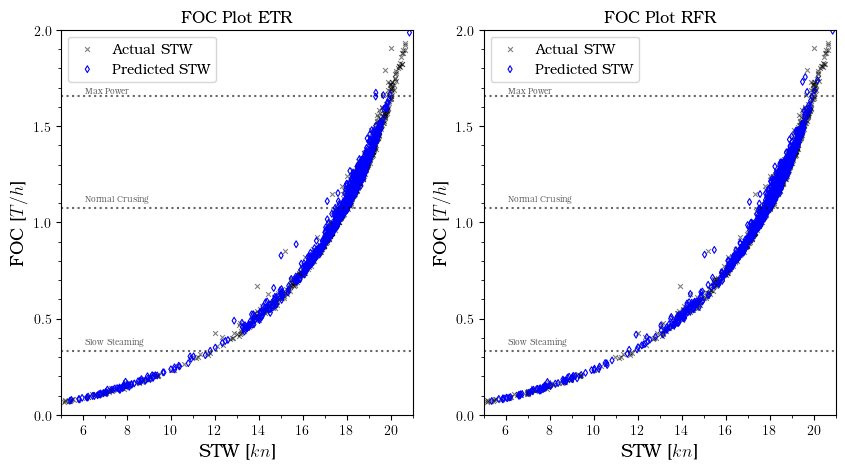

In [116]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('ETR',stw_pred_et_yr,stw_act_yr,FOC_pred_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('RFR',stw_pred_rf_yr,stw_act_yr,FOC_pred_rf_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

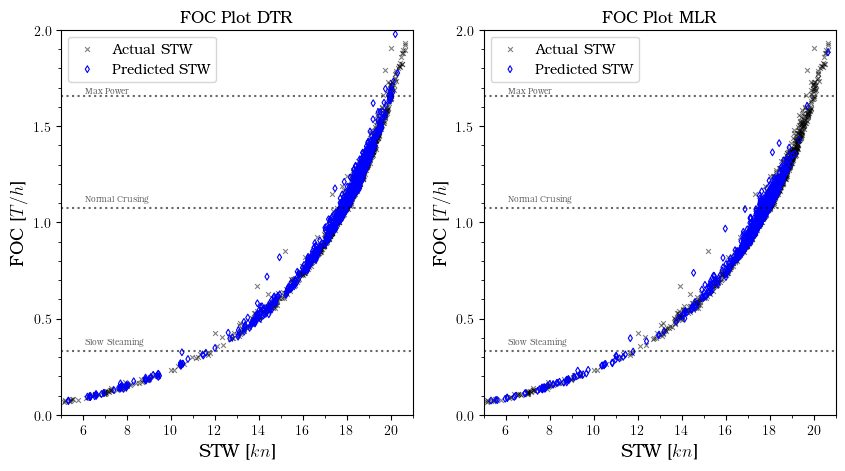

In [117]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
FOC_coeff_plot('DTR',stw_pred_dt_yr,stw_act_yr,FOC_pred_dt_yr,FOC_act_yr)
plt.sca(axes[1])
FOC_coeff_plot('MLR',stw_pred_mlr_yr,stw_act_yr,FOC_pred_mlr_yr,FOC_act_yr)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.2)
plt.show()

Actual data polyfit

Best Polynomial Equation:
$y = 0.6931 + (-0.2834)x^1 + (0.0444)x^2 + (-0.0027)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.6302 + (-0.2625)x^1 + (0.0419)x^2 + (-0.0026)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.7228 + (-0.2881)x^1 + (0.0441)x^2 + (-0.0027)x^3 + (0.0001)x^4$


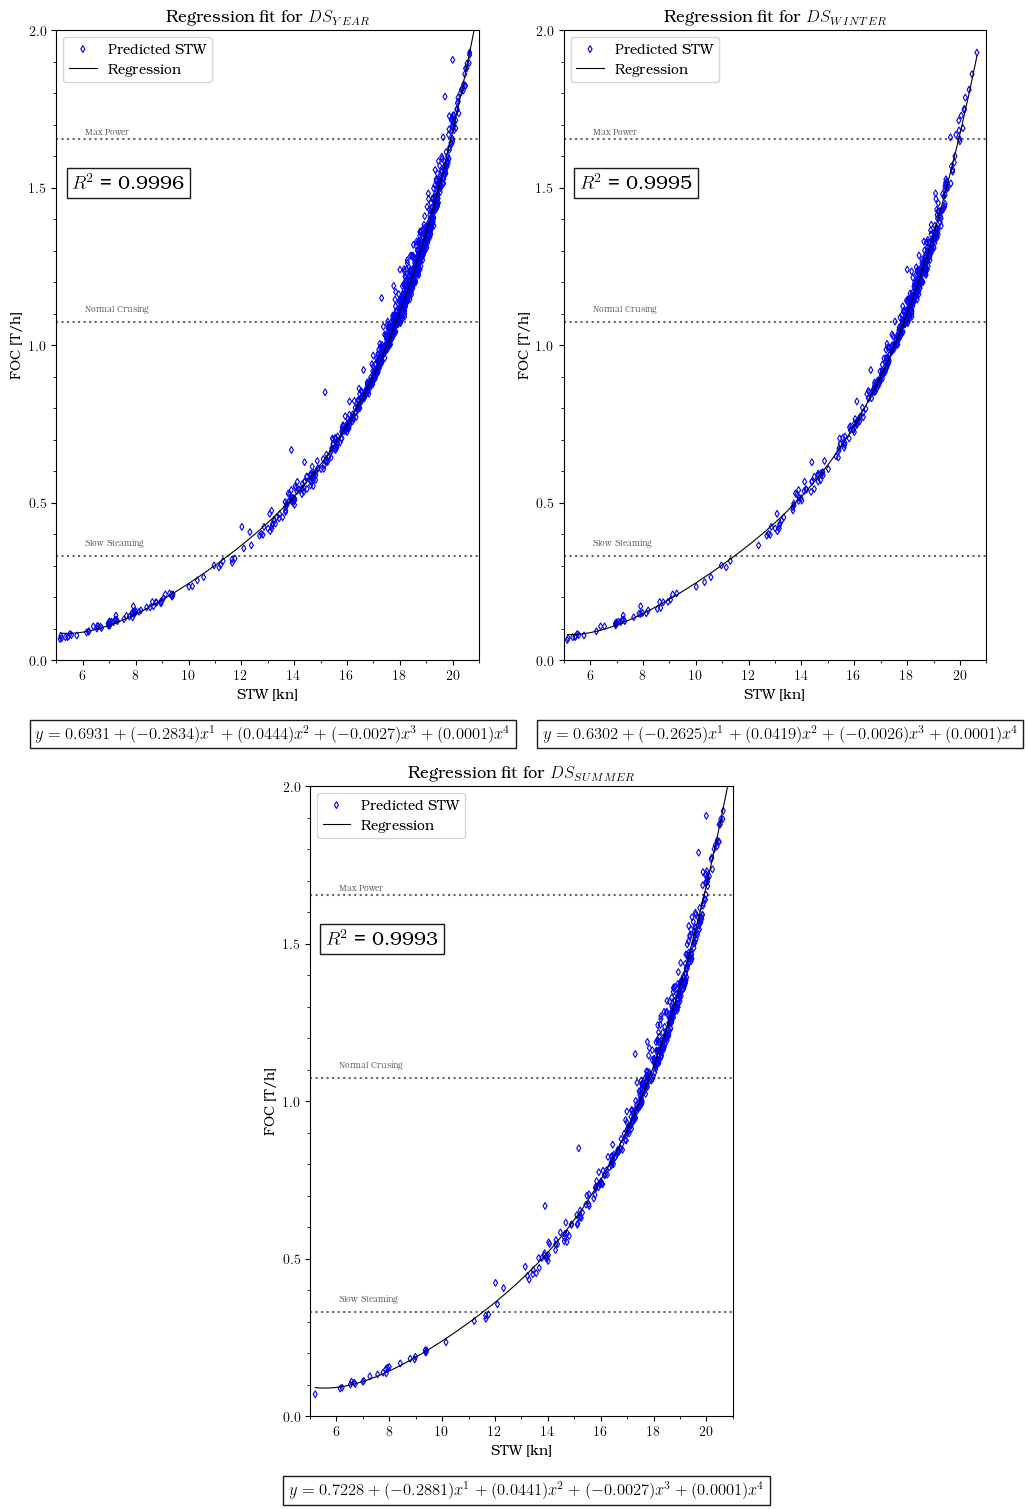

In [118]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_act_yr = poly_reg_best_fit('DS_{YEAR}',stw_act_yr,FOC_act_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_act_s = poly_reg_best_fit('DS_{WINTER}',stw_act_w,FOC_act_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_act_w = poly_reg_best_fit('DS_{SUMMER}',stw_act_s,FOC_act_s)
plt.show()

ETR polyfit plot

Best Polynomial Equation:
$y = 0.6074 + (-0.2462)x^1 + (0.0389)x^2 + (-0.0024)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.5791 + (-0.2413)x^1 + (0.0389)x^2 + (-0.0024)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.5926 + (-0.2330)x^1 + (0.0361)x^2 + (-0.0022)x^3 + (0.0001)x^4$


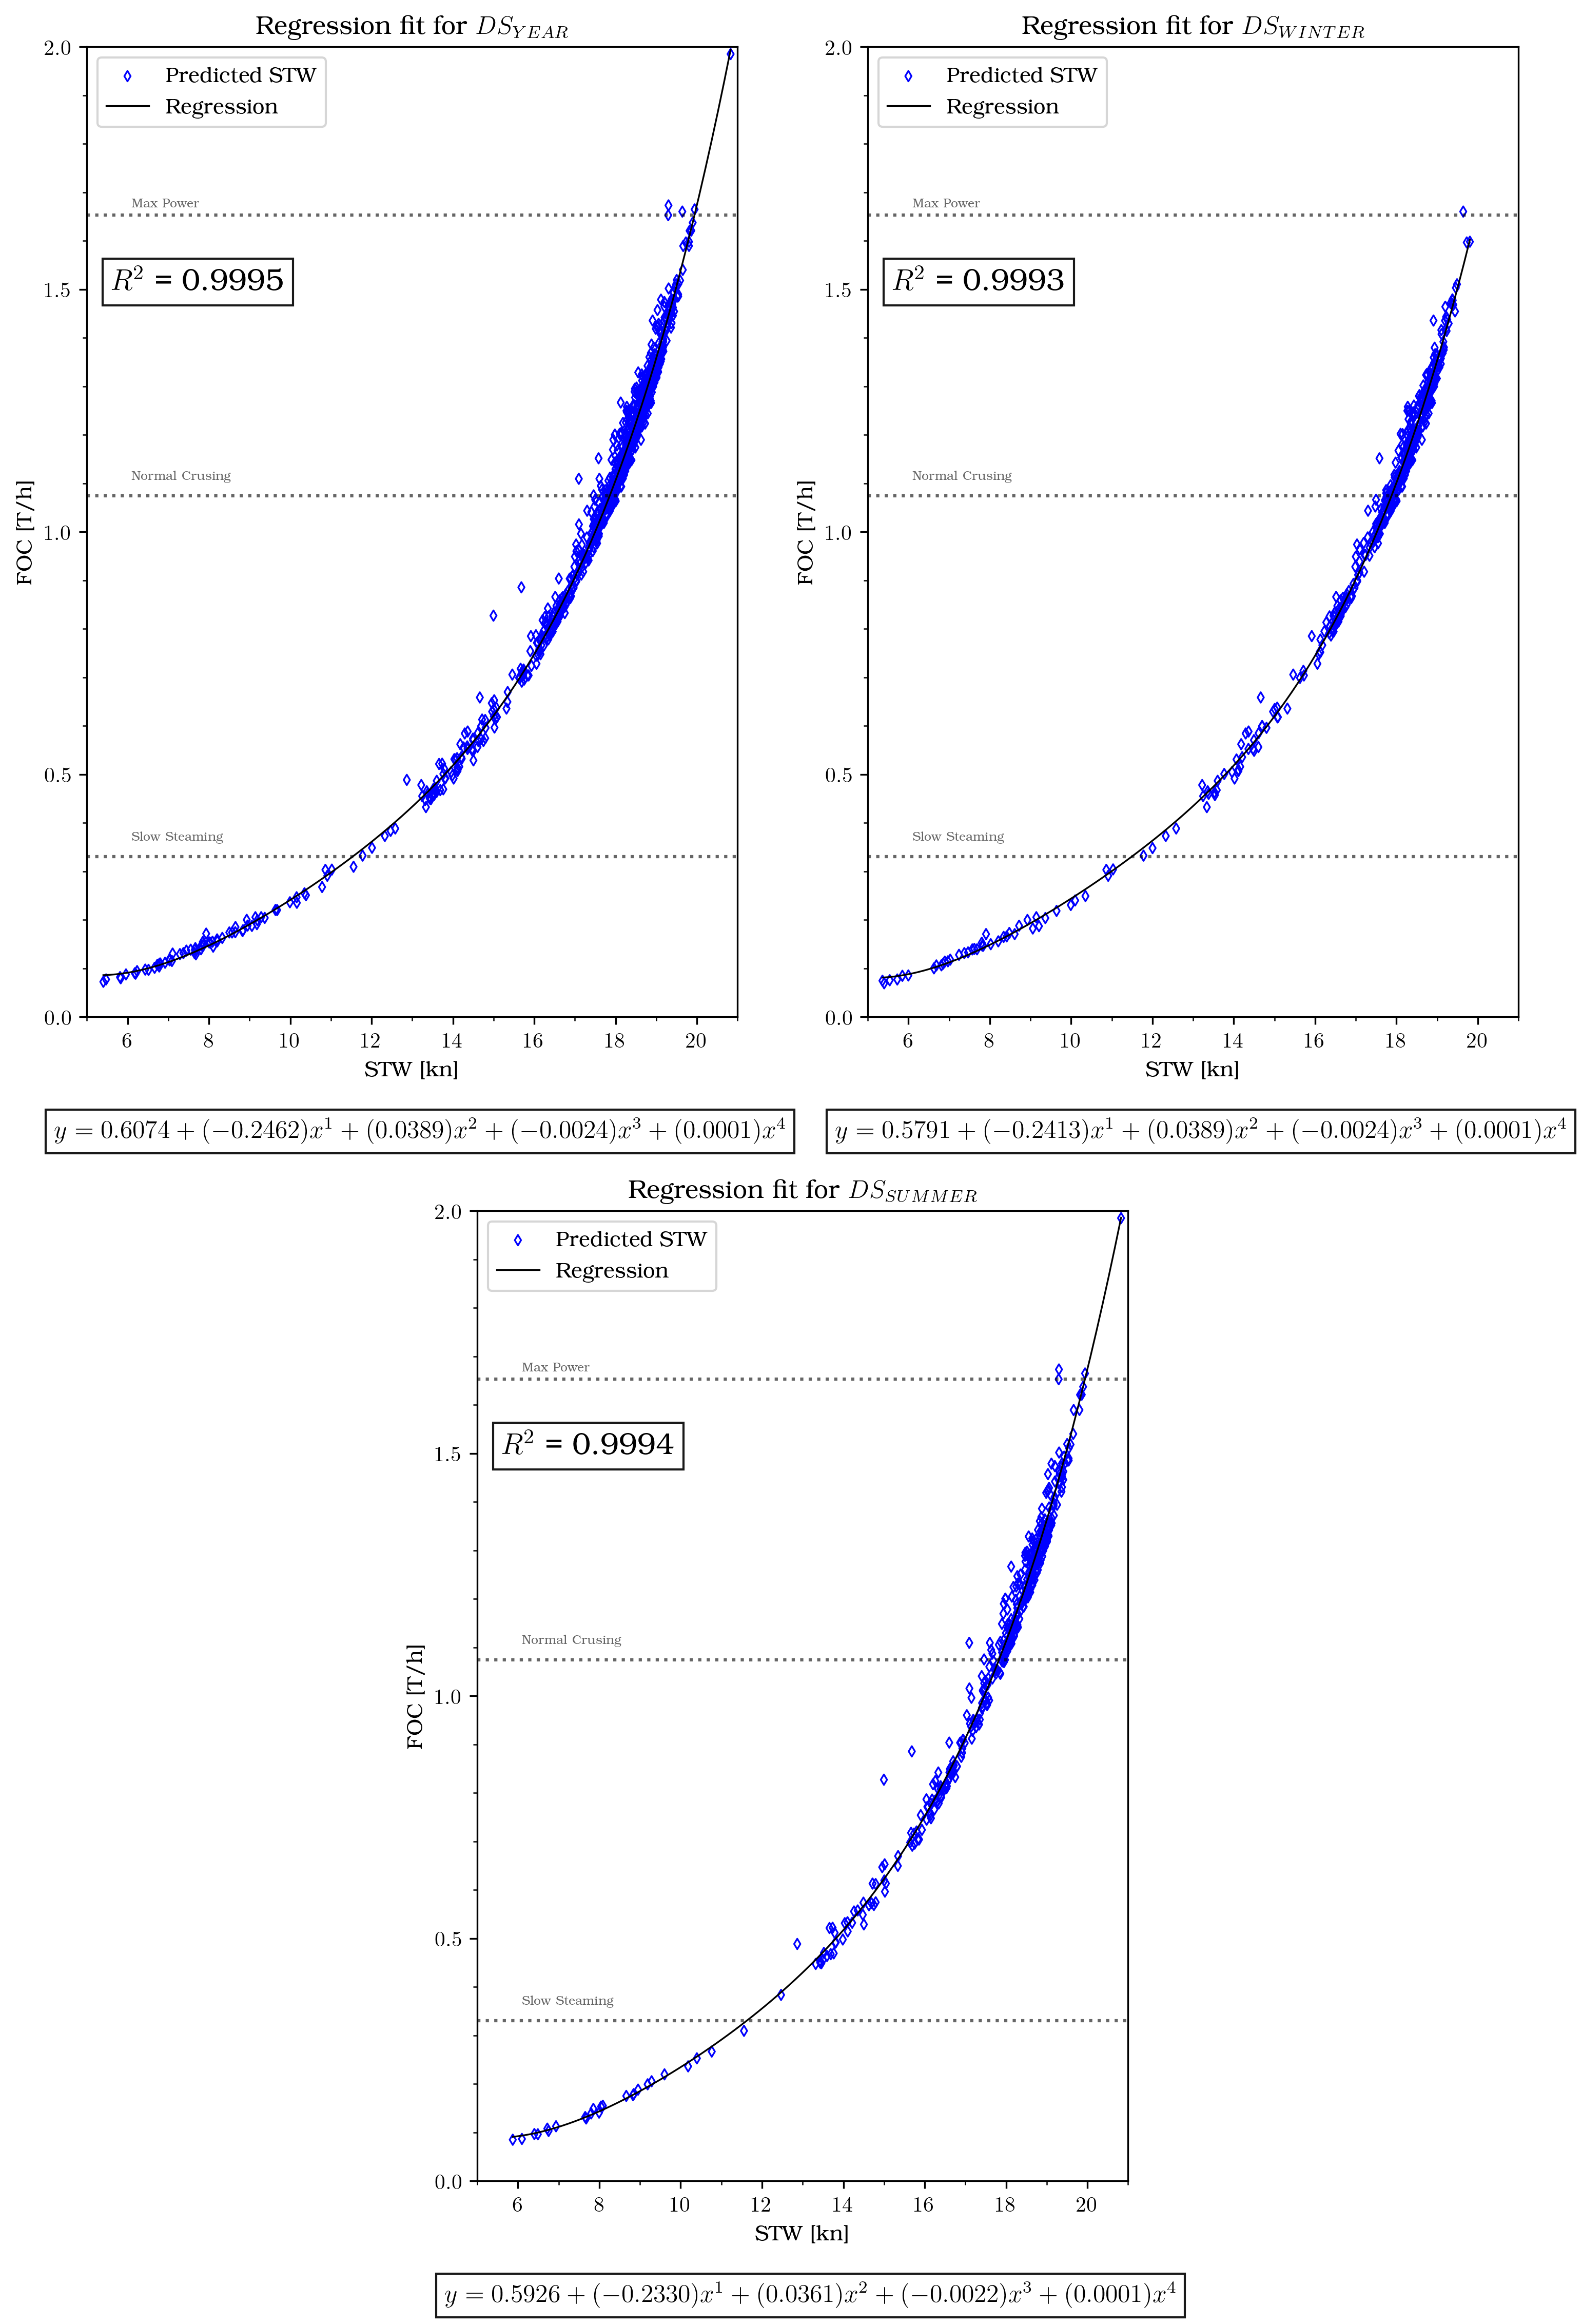

In [119]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_etr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_et_yr,FOC_pred_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_etr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_et_w,FOC_pred_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_etr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_et_s,FOC_pred_s)
plt.show()

RFR polyfit FOC

Best Polynomial Equation:
$y = 0.6388 + (-0.2580)x^1 + (0.0404)x^2 + (-0.0025)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.5989 + (-0.2488)x^1 + (0.0399)x^2 + (-0.0025)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.6073 + (-0.2409)x^1 + (0.0373)x^2 + (-0.0023)x^3 + (0.0001)x^4$


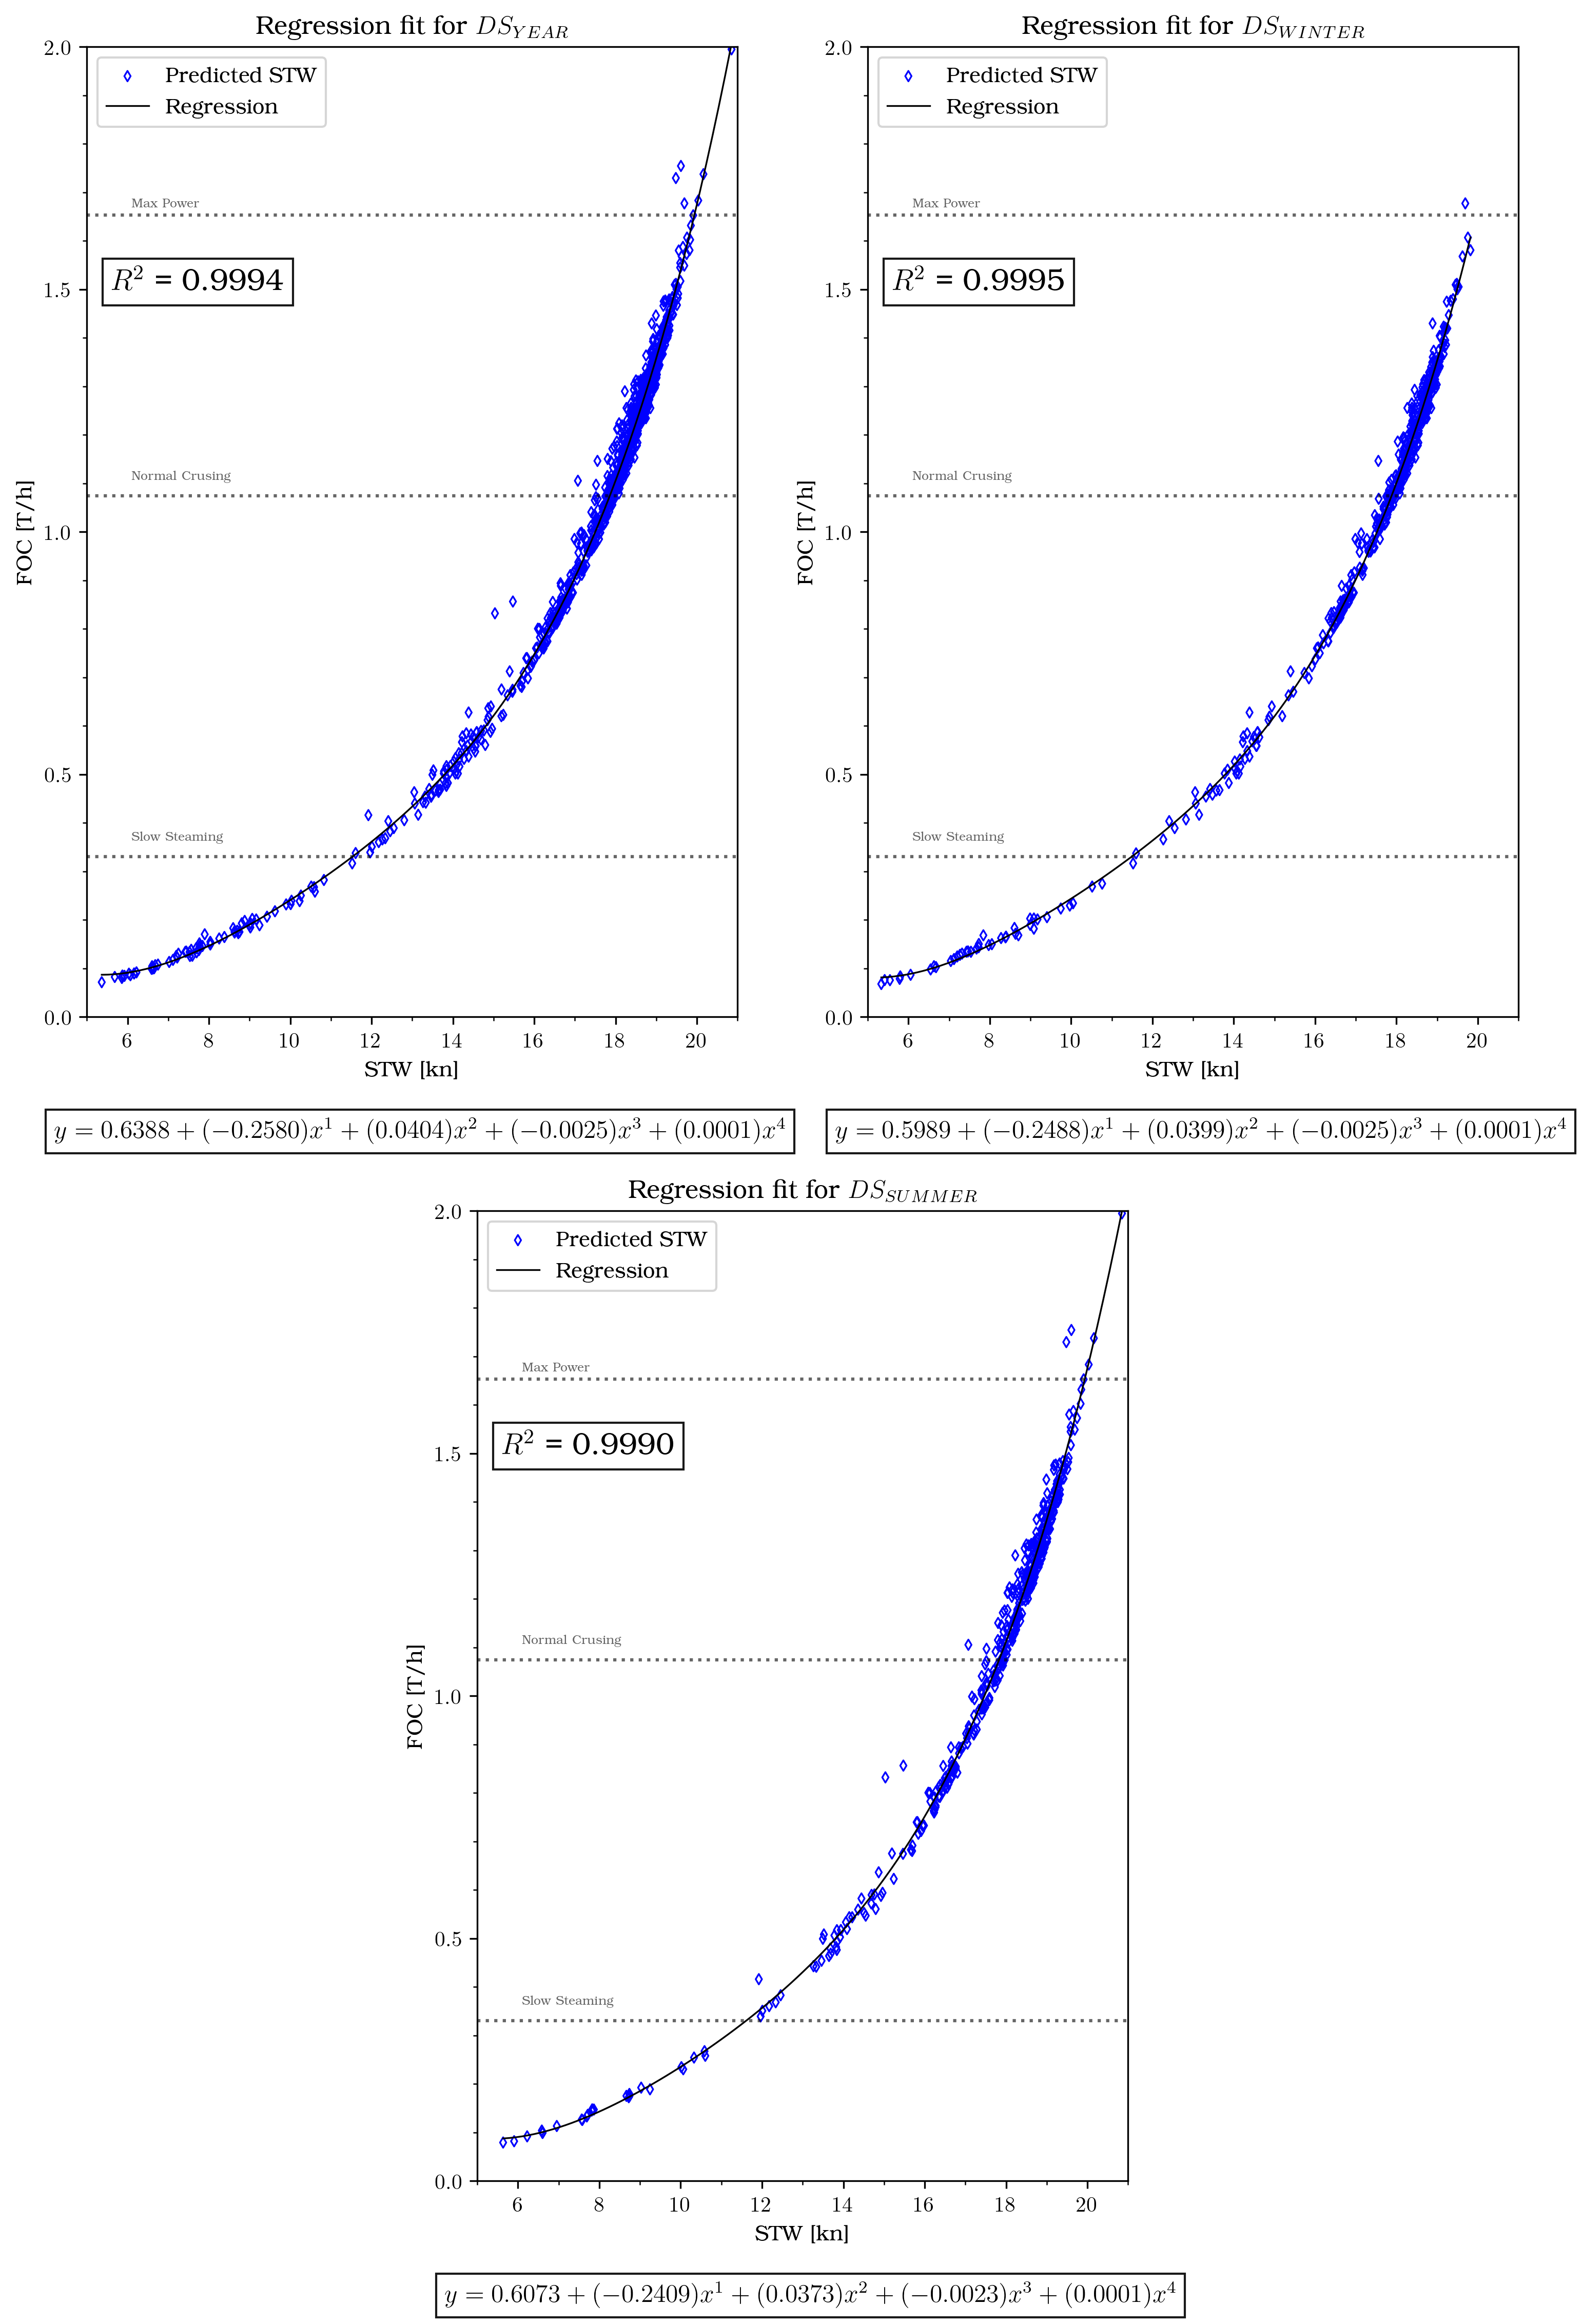

In [120]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_rfr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_rf_yr,FOC_pred_rf_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_rfr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_rf_w,FOC_pred_rf_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_rfr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_rf_s,FOC_pred_rf_s)
plt.show()

DTR

Best Polynomial Equation:
$y = 0.7027 + (-0.2818)x^1 + (0.0436)x^2 + (-0.0027)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.6513 + (-0.2676)x^1 + (0.0423)x^2 + (-0.0026)x^3 + (0.0001)x^4$
Best Polynomial Equation:
$y = 0.6994 + (-0.2741)x^1 + (0.0417)x^2 + (-0.0025)x^3 + (0.0001)x^4$


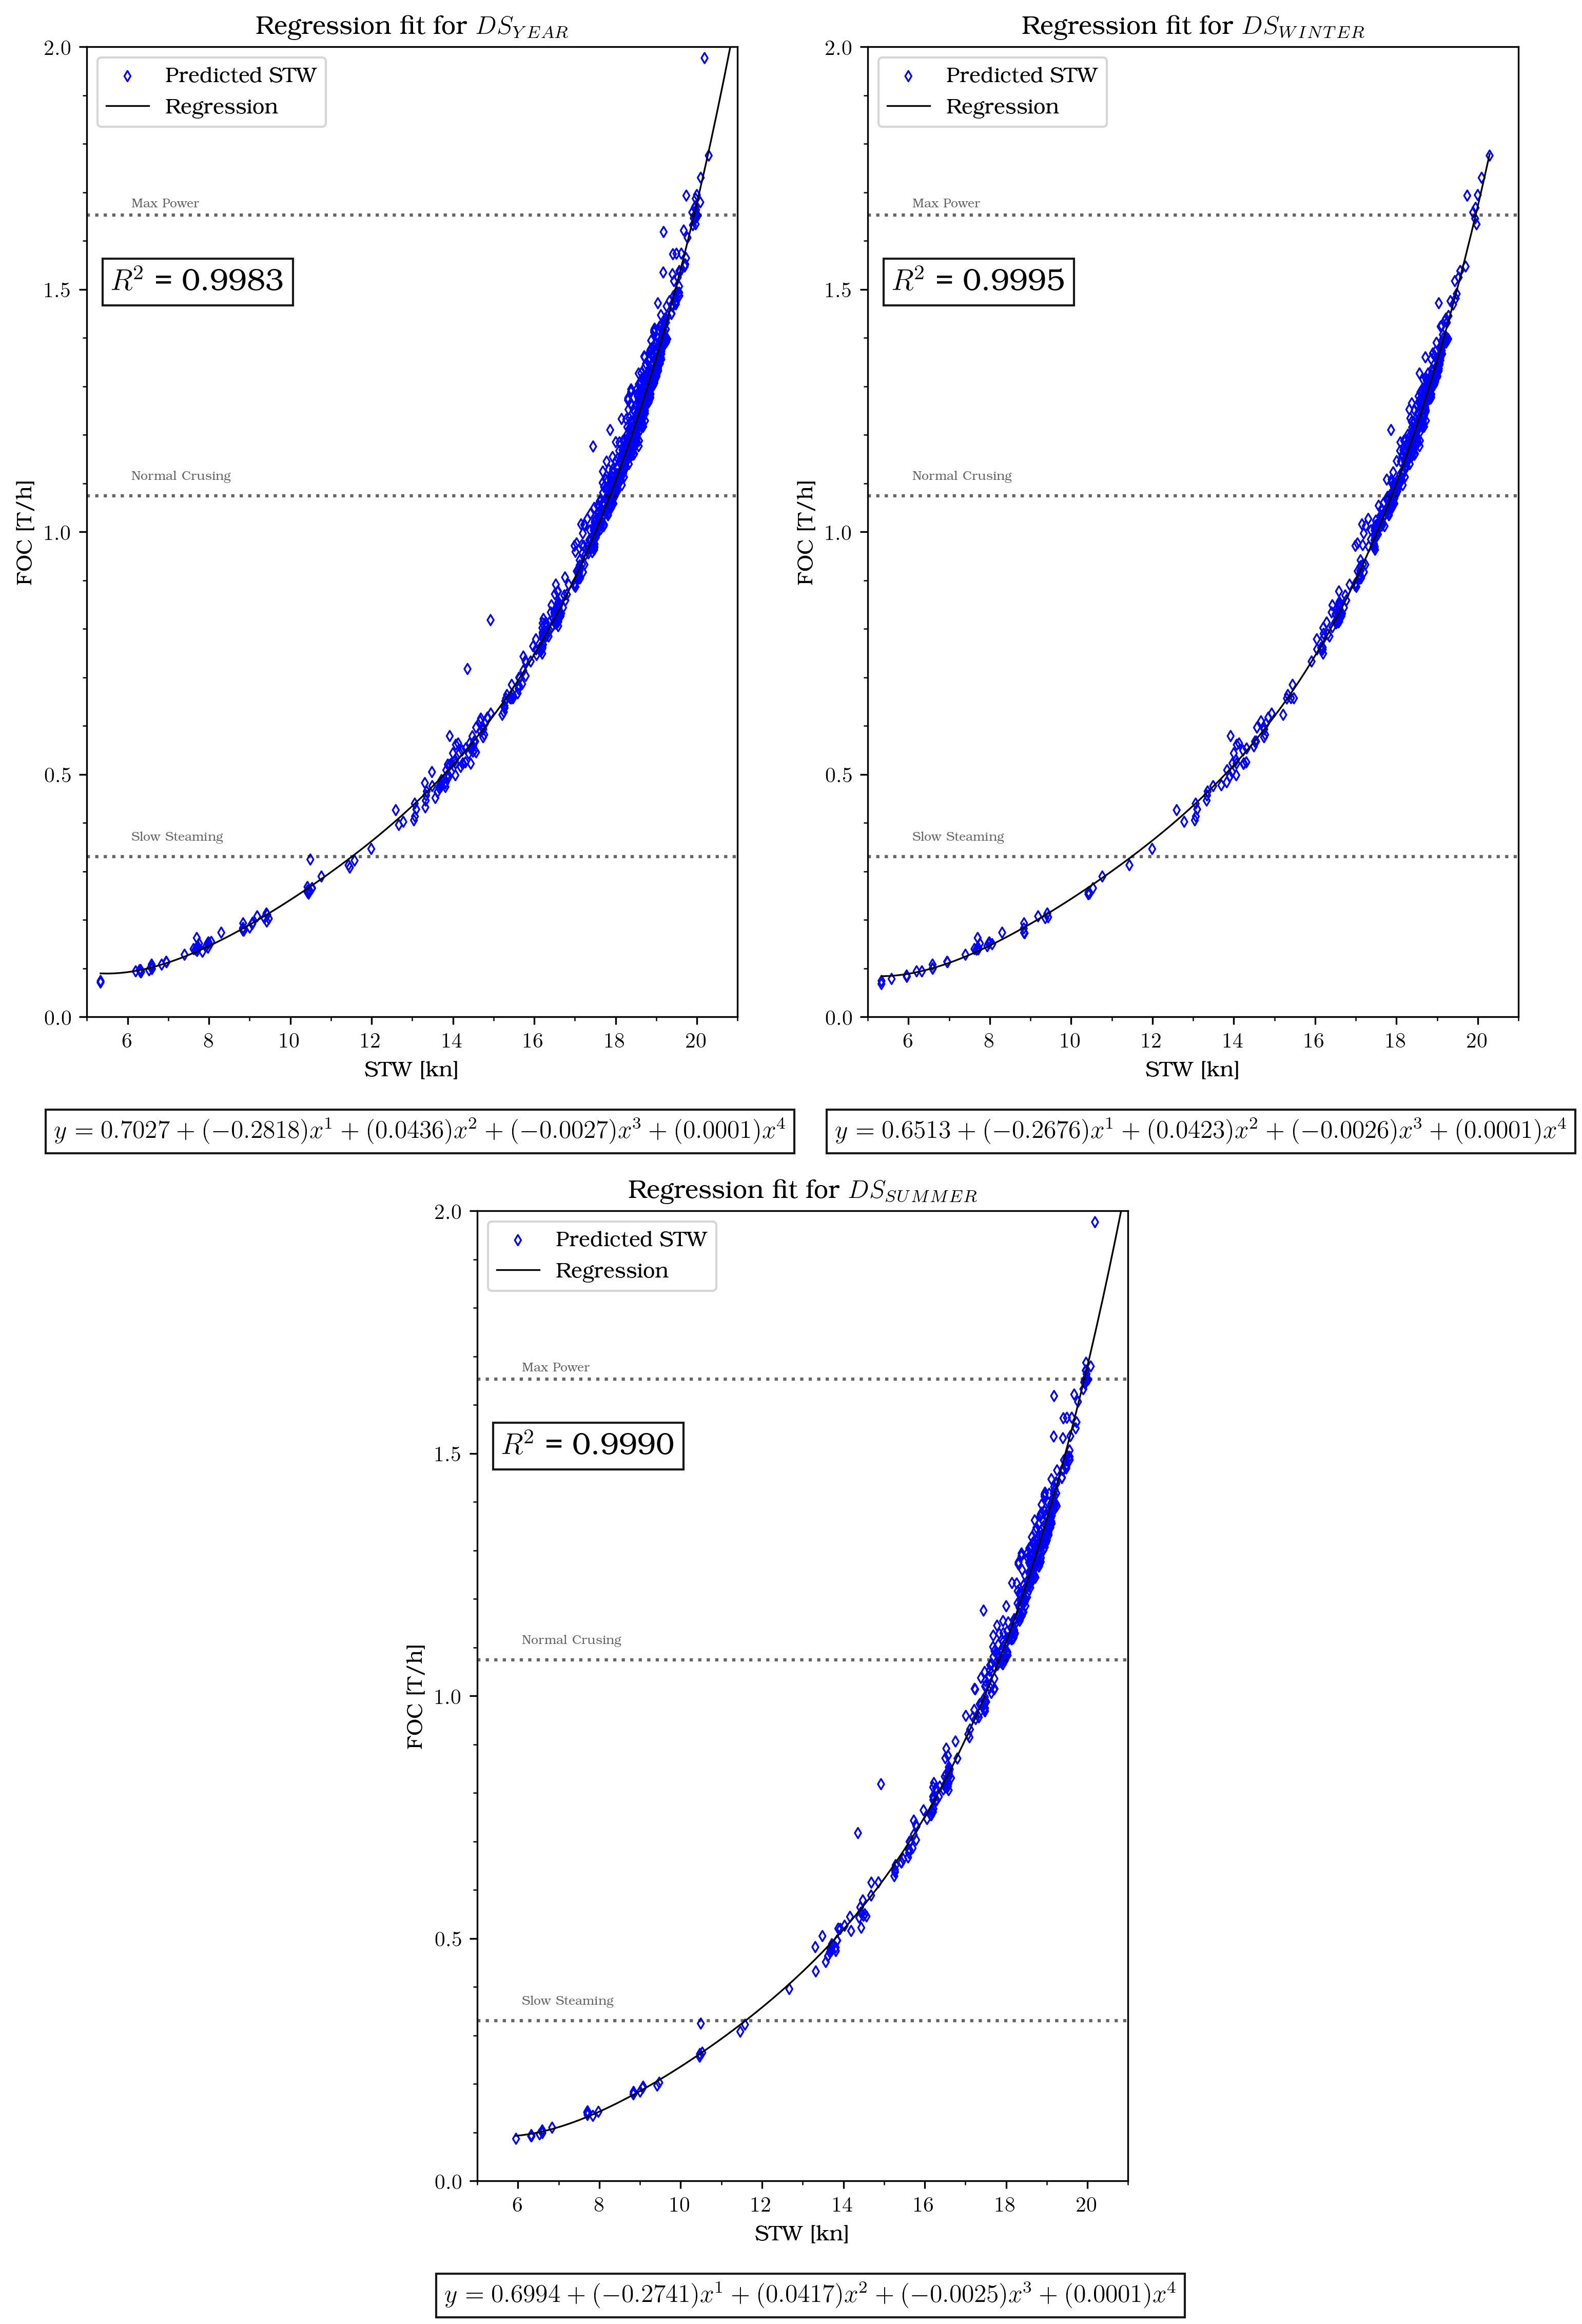

In [121]:
plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2] )
poly_dtr_yr = poly_reg_best_fit('DS_{YEAR}',stw_pred_dt_yr,FOC_pred_dt_yr)
ax2 = plt.subplot(gs[0, 2:])
poly_dtr_w = poly_reg_best_fit('DS_{WINTER}',stw_pred_dt_w,FOC_pred_dt_w)
ax3 = plt.subplot(gs[1, 1:3])
poly_dtr_s = poly_reg_best_fit('DS_{SUMMER}',stw_pred_dt_s,FOC_pred_dt_s)
plt.show()

Absolute model performance

In [122]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = np.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    print(f"Model Performance of {model}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MAE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


ETR

In [123]:
# Yearly performance 

evaluate_FOC(model_etr_hpov,FOC_act_yr,FOC_pred_yr)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8383
Explained Variance 0.8400
MAE 0.1112 T/h
RMSE FOC 0.1607 T/h
MAD 0.0758 T/h
MAPE FOC 12.4477 %


In [124]:
evaluate_FOC(model_etr_hpov,FOC_act_s,FOC_pred_s)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.7986
Explained Variance 0.8049
MAE 0.1268 T/h
RMSE FOC 0.1848 T/h
MAD 0.0818 T/h
MAPE FOC 13.5900 %


In [125]:
evaluate_FOC(model_etr_hpov,FOC_act_w,FOC_pred_w)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 0.8758
Explained Variance 0.8758
MAE 0.0969 T/h
RMSE FOC 0.1353 T/h
MAD 0.0673 T/h
MAPE FOC 11.3473 %


RFR

In [126]:
# On yearly data

evaluate_FOC(model_rfr_hpov,FOC_act_yr,FOC_pred_rf_yr)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8181
Explained Variance 0.8187
MAE 0.1167 T/h
RMSE FOC 0.1705 T/h
MAD 0.0784 T/h
MAPE FOC 13.6419 %


In [127]:
evaluate_FOC(model_rfr_hpov,FOC_act_s,FOC_pred_rf_s)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.7682
Explained Variance 0.7720
MAE 0.1365 T/h
RMSE FOC 0.1982 T/h
MAD 0.0883 T/h
MAPE FOC 15.3111 %


In [128]:
evaluate_FOC(model_rfr_hpov,FOC_act_w,FOC_pred_rf_w)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 0.8657
Explained Variance 0.8658
MAE 0.0987 T/h
RMSE FOC 0.1407 T/h
MAD 0.0684 T/h
MAPE FOC 12.0566 %


DTR

In [129]:
evaluate_FOC(model_dtr_hpov,FOC_act_yr,FOC_pred_dt_yr)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7658
Explained Variance 0.7663
MAE 0.1331 T/h
RMSE FOC 0.1934 T/h
MAD 0.0865 T/h
MAPE FOC 15.7779 %


In [130]:
evaluate_FOC(model_dtr_hpov,FOC_act_s,FOC_pred_dt_s)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7442
Explained Variance 0.7472
MAE 0.1444 T/h
RMSE FOC 0.2082 T/h
MAD 0.0967 T/h
MAPE FOC 16.1565 %


In [131]:
evaluate_FOC(model_dtr_hpov,FOC_act_w,FOC_pred_dt_w)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 0.7826
Explained Variance 0.7827
MAE 0.1228 T/h
RMSE FOC 0.1790 T/h
MAD 0.0801 T/h
MAPE FOC 15.3457 %


MLR

In [132]:
#yearly data

evaluate_FOC(model_mlr_ftr,FOC_act_yr,FOC_pred_mlr_yr)

Model Performance of LinearRegression()
R^2 0.2916
Explained Variance 0.3181
MAE 0.2232 T/h
RMSE FOC 0.3365 T/h
MAD 0.1705 T/h
MAPE FOC 29.3904 %


In [133]:
evaluate_FOC(model_mlr_ftr,FOC_act_s,FOC_pred_mlr_s)

Model Performance of LinearRegression()
R^2 0.4433
Explained Variance 0.4966
MAE 0.2351 T/h
RMSE FOC 0.3072 T/h
MAD 0.1911 T/h
MAPE FOC 25.2405 %


In [134]:
evaluate_FOC(model_mlr_ftr,FOC_act_w,FOC_pred_mlr_w)

Model Performance of LinearRegression()
R^2 0.1039
Explained Variance 0.1137
MAE 0.2119 T/h
RMSE FOC 0.3634 T/h
MAD 0.1606 T/h
MAPE FOC 33.1927 %


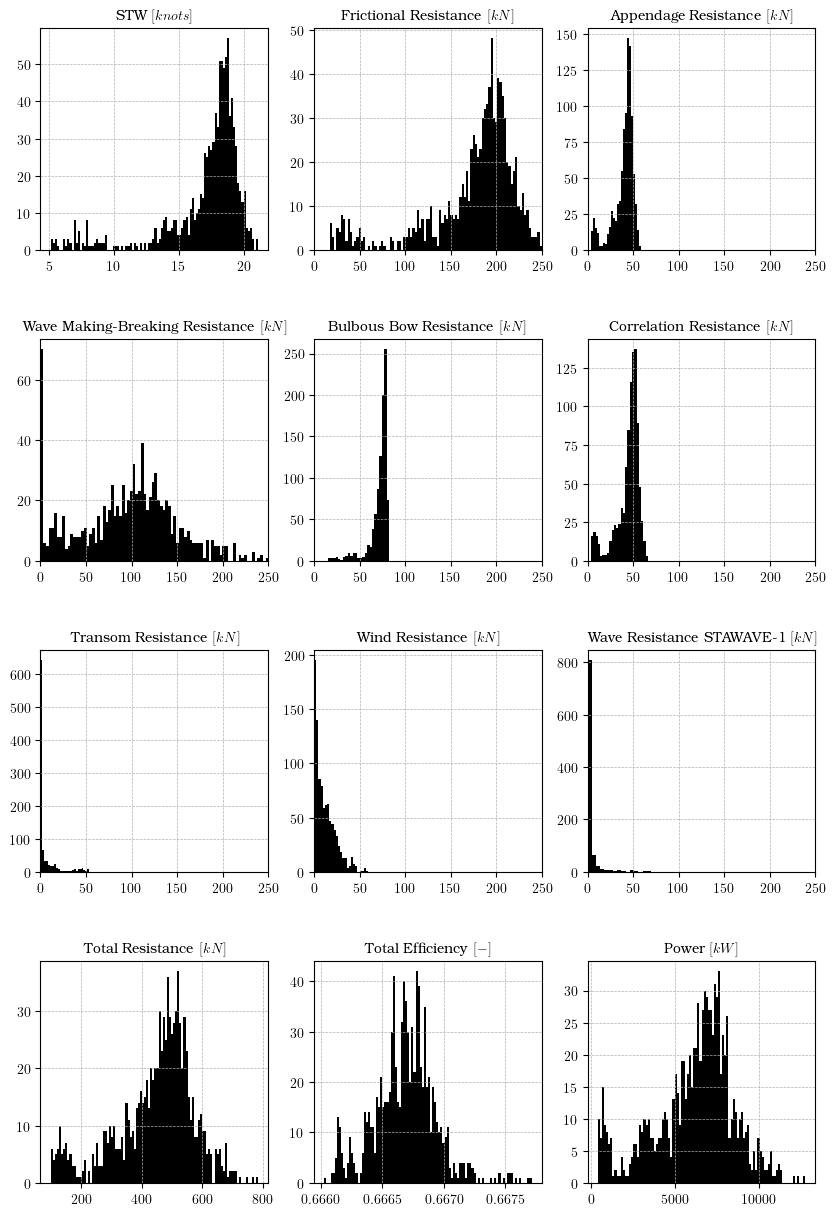

In [135]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = stw_act_yr
R_f = Rf_act_yr/1e3
R_app = R_app_act_yr/1e3
R_w = R_w_act_yr/1e3
R_b = R_b_act_yr/1e3
R_tr = R_tr_act_yr/1e3
R_a = R_a_act_yr/1e3
R_aa = R_aa_act_yr/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = R_awl_act_yr/1e3
R_tot = R_tot_act_yr
# eff_h = dfprog_f['eff_h']
eff_tot = eff_tot_act_yr
P_b = P_b_act_yr
FOC = FOC_act_yr



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=100,color='black')
axes[0, 0].set_title(r'STW $[knots]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=100,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 1].set_xlim(0,250)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[0, 2].set_xlim(0,250)

axes[1, 0].hist(R_w,bins=100,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 0].set_xlim(0,250)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 1].set_xlim(0,250)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[1, 2].set_xlim(0,250)

axes[2, 1].hist(R_aa,bins=25,color='black')
axes[2, 1].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 1].set_xlim(0,250)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_awl,bins=25,color='black')
axes[2, 2].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 2].set_xlim(0,250)

axes[2, 0].hist(R_tr,bins=25,color='black')
axes[2, 0].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)
axes[2, 0].set_xlim(0,250)

axes[3, 0].hist(R_tot,bins=100,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=100,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=100,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

In [136]:
def FOC_plot_yr(FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr):
    rmse_opt = [FOC_actual_yr,FOC_ETR_yr,FOC_RFR_yr,FOC_DTR_yr]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("FOC comparison for yearly data")
    plt.ylabel("FOC [T/h]")
    plt.xlabel("Period")
    plt.yscale('linear')
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'$FOC_{actual}$', r'$FOC_{ETR}$',
                        r'$FOC_{RFR}$', r'$FOC_{DTR}$'])

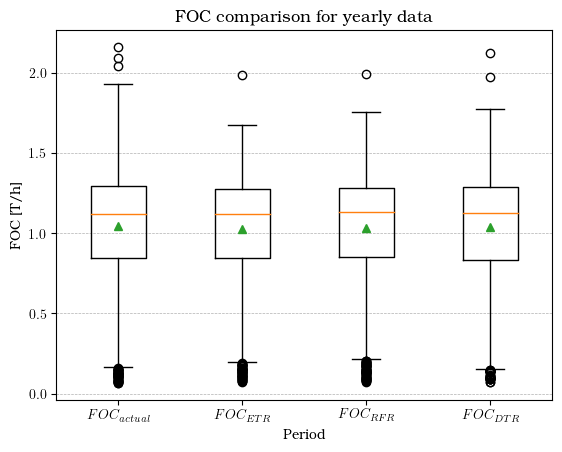

In [137]:
FOC_plot_yr(FOC_act_yr,FOC_pred_yr,FOC_pred_rf_yr,FOC_pred_dt_yr)
plt.show()